In [1]:
""" import useful functions """

# Generic
import pandas as pd
import numpy as np
import scipy
from itertools import islice, cycle
import math
import os
import sys
from scipy.integrate import odeint
from joblib import Parallel, delayed
import itertools
from importlib import reload
from functools import lru_cache
import scipy.integrate
import seaborn as sns
# cosmology
import pyccl as ccl
from astropy.io import fits
import yaml
import sacc
import time

# covariance - Charlie's version of TJPCov
MODULE_PATH = "/home/c2042999/TJPCov/tjpcov/__init__.py"
MODULE_NAME = "tjpcov"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from tjpcov.covariance_calculator import CovarianceCalculator

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# SRD Binning
import srd_redshift_distributions as srd
import binning

# Data Visualization
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.graph_objs as go
import matplotlib
#import seaborn as sns

# MCMC
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from chainconsumer import ChainConsumer, Chain, make_sample
from IPython.display import display, Math
from multiprocessing import Pool
from tqdm import tqdm

# nDGP NL and lin Pk
from nDGPemu import BoostPredictor

# MGCAMB
MODULE_PATH = "/home/c2042999/MGCAMB/camb/__init__.py"
MODULE_NAME = "MGCAMB"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from MGCAMB import camb

# f(R) emu (eMANTIS)
from emantis import FofrBoost

In [2]:
print(emcee.__version__)

3.1.6


In [3]:
#reload(camb)

In [5]:
"""For tests"""

cosmo_testing = ccl.Cosmology(Omega_c = 0.25, 
                          Omega_b = 0.05,
                          h = 0.7,
                          n_s = 0.962,
                          A_s = 2.1e-9)

cosmo_testing_linear = ccl.Cosmology(Omega_c = 0.25, 
                          Omega_b = 0.05,
                          h = 0.7,
                          n_s = 0.962,
                          A_s = 2.1e-9,
                          matter_power_spectrum='linear')

In [28]:
# Initialise EMANTIS emulator.
emu_fR = FofrBoost()

"""Initialize some things (e.g. emulators)"""
# Load the nDGP emulator
model_nDGP = BoostPredictor()


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# 1. Create mock redshift distribution (define z and output Binned_distribution(z))

In [7]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.01, 3.5, 500)
forecast_years = ["1", "10"]  # Assuming integers are appropriate

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

for year in forecast_years:
    source_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=True,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=True,
                                                                                save_file=False)

# Uncomment to check if the dictionary is populated correctly
# print(redshift_distribution["sources"].keys())


bins = {
    "sources": {},
    "lenses": {}
}

# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = binning.Binning(redshift_range, 
                                            redshift_distribution["sources"][year],
                                            year).source_bins(normalised=True,
                                                              save_file=False)
    bins["lenses"][year] = binning.Binning(redshift_range, 
                                           redshift_distribution["lenses"][year],
                                           year).lens_bins(normalised=True,
                                                           save_file=False)


#(5, 256)
Binned_distribution_lens = [list(bins["lenses"]["1"].items())[0][1]]
for i in range(4):
    Binned_distribution_lens = np.append(Binned_distribution_lens,\
               [list(bins["lenses"]["1"].items())[i+1][1]], axis=0)

Binned_distribution_source = [list(bins["sources"]["1"].items())[0][1]]
for i in range(4):
    Binned_distribution_source = np.append(Binned_distribution_source,\
               [list(bins["sources"]["1"].items())[i+1][1]], axis=0)
    
print(Binned_distribution_lens.shape)
print(Binned_distribution_source.shape)
print(redshift_range.shape)

(5, 500)
(5, 500)
(500,)


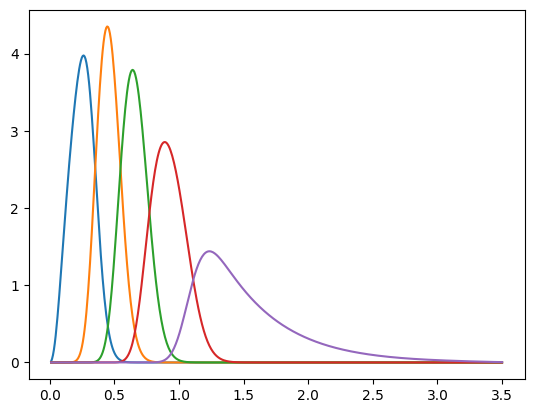

In [8]:
## TEST1: Plots to check binned source redshift distribution
z = redshift_range

plt.plot(z ,Binned_distribution_source[0])
plt.plot(z ,Binned_distribution_source[1])
plt.plot(z ,Binned_distribution_source[2])
plt.plot(z ,Binned_distribution_source[3])
plt.plot(z ,Binned_distribution_source[len(Binned_distribution_source)-1])


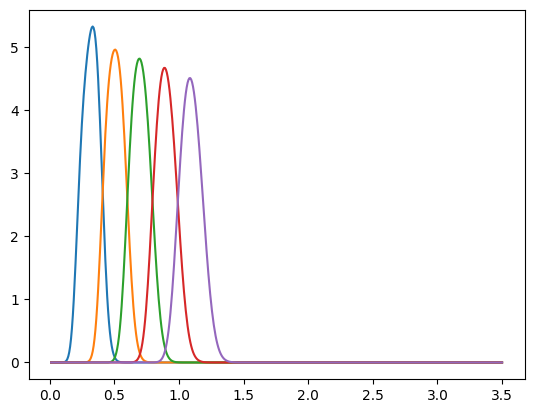

In [9]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z ,Binned_distribution_lens[0])
plt.plot(z ,Binned_distribution_lens[1])
plt.plot(z ,Binned_distribution_lens[2])
plt.plot(z ,Binned_distribution_lens[3])
plt.plot(z ,Binned_distribution_lens[len(Binned_distribution_lens)-1])

## 1b. Create mock bias distribution

In [10]:
# Match SRD
# from Table 2 in https://arxiv.org/pdf/2212.09345

Bias_distribution_fiducial = np.array([1.562362*np.ones(len(z)),
                             1.732963*np.ones(len(z)),
                             1.913252*np.ones(len(z)),
                             2.100644*np.ones(len(z)),
                             2.293210*np.ones(len(z))])


# 2. Define functions to get various (P(k)) from Emulators, etc.

The power spectrum in $\Lambda$CDM and nDGP is the same in the early universe (i.e. $\approx z=49$). This means we have:

$P_{\delta}(z=49) = \Big(\frac{\delta^{\Lambda CDM}(z=49)}{\delta^{\Lambda CDM}(z=0)}\Big)^2P^{\Lambda CDM}_{\delta}(z=0) = \Big(\frac{\delta^{nDGP}(z=49)}{\delta^{nDGP}(z=z_{ini})}\Big)^2P^{nDGP}_{\delta}(z=z_{ini})$

Therefore 

$P^{nDGP}_{\delta}(z=z_{ini}) = \Big(\frac{D_+^{\Lambda CDM}(z=49)}{D_+^{nDGP}(z=49)} \times \frac{D_+^{nDGP}(z=z_{ini})}{D_+^{\Lambda CDM}(z=z_{ini})}
\Big)^2P^{\Lambda CDM}_{\delta}(z=0)$

where $D_+(z=0) = 1$.

## Non-linear matter power spectra (f(R) and nDGP)

In [11]:
"""Non-linear matter power spectra (f(R) and nDGP)"""

# NL matter power spectra in nDGP
def P_k_NL_nDGP(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output Pk_nDGP (array) -> Nonlinear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    # Turn k into units of h/Mpc
    k = k/cosmo["h"]

    H0rc, fR0, n, mu, Sigma = MGparams

    # nDGP emulator - get boost
    cosmo_params = {'Om':cosmo["Omega_m"],
                    'ns':cosmo["n_s"],
                    'As':cosmo["A_s"],
                    'h':cosmo["h"],
                    'Ob':cosmo["Omega_b"]}

    pkratio_nDGP = model_nDGP.predict(H0rc, 1/a -1 , cosmo_params, k_out=k)

    # Get GR power spectrum
    
    Pk_ccl = ccl.power.nonlin_power(cosmo, k*cosmo["h"], a=a) # units (Mpc)^3
    return pkratio_nDGP*Pk_ccl

# NL matter power spectra in fR
def P_k_NL_fR(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output Pk_fR (array) -> Nonlinear matter power spectrum for Hu-Sawicki fR gravity, units (Mpc)^3
    """
    H0rc, fR0, n, mu, Sigma = MGparams

    sigma8_VAL_lcdm = ccl.sigma8(cosmo)
    
    pkratio_fR = emu_fR.predict_boost(cosmo["Omega_m"], sigma8_VAL_lcdm, -np.log10(fR0), a, k = k/cosmo["h"])
    # k is in units [h/Mpc]

    Pk_ccl = ccl.power.nonlin_power(cosmo, k, a=a) # units (Mpc)^3
    Pk = pkratio_fR*Pk_ccl

    return Pk

## Linear matter power spectra (f(R) and nDGP)

In [12]:
"""Linear matter power spectra nDGP"""

# dimensionless hubble parameter in GR
def E(cosmoMCMCStep, a):
    Omg_r = cosmoMCMCStep["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    return np.sqrt(cosmoMCMCStep["Omega_m"]/a**3 +Omg_r/a**4 + (1 - cosmoMCMCStep["Omega_m"] - Omg_r))

# deriv. of E wrt scale factor, GR
def dEda(cosmo, a):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    E_val = E(cosmo, a)
    
    return (-3*cosmo["Omega_m"]/a**4 -4*Omg_r/a**5)/2/E_val

# mu(k,a) = mu(a) in nDGP (modified gravity parametrization parameter)
def mu_nDGP(MGparams, cosmo, a):
    H0rc, fR0, n, mu, Sigma = MGparams
    if H0rc == 0: # just by convention, we want MGParams = [0,0,0,0] to be gr
        return 1
    elif 1/(4*H0rc**2) == 0:
        return 1
    else:
        Omg_rc = 1/(4*H0rc**2)
        E_val = E(cosmo, a)
        # from ReACT paper
        beta = 1 + E_val/np.sqrt(Omg_rc) * (1+ a*dEda(cosmo, a)/3/E_val)
        return 1 + 1/3/beta
    
def solverGrowth_nDGP(y,a,cosmo, MGparams):
    E_val = E(cosmo, a)
    D , a3EdDda = y
    
    mu = mu_nDGP(MGparams, cosmo, a)
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(mu)/(2*E_val*a**2)]
    return ydot
    
def P_k_nDGP_lin(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n,mu])
    
    output Pk_nDGP (array) -> linear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    
    # Get growth factor in nDGP and GR
    H0rc, fR0, n, mu, Sigma = MGparams
    
    Omega_rc = 1/(4*H0rc**2)
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo,[0,0,0,0,0]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    
    Pk_GR = ccl.linear_matter_power(cosmo, k=k, a=a)

    # find the index for matter domination)
    #idx_mdom = np.argmax(a_solver**(-3) / E(cosmo, a_solver)**2)          
    idx_mdom = 0
    # get normalization at matter domination
    Delta_nDGP_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    return Pk_GR * np.interp(a, a_solver, (Delta / Delta_nDGP_49) **2 / (Delta_GR / Delta_GR_49)**2)  # units (Mpc)^3


In [13]:
"""Linear matter power spectra f(R)"""

@lru_cache(maxsize=128)  # You can adjust maxsize according to your memory constraints
def create_interpolator(cosmo_values, MGparams_tuple):
    
    H0rc, fR0, n, mu, Sigma = MGparams_tuple

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_values['h'] * 100, 
                       ombh2=cosmo_values['Omega_b'] * cosmo_values['h']**2, 
                       omch2=cosmo_values['Omega_c'] * cosmo_values['h']**2, 
                       omk=0, mnu=0.0)
    pars.InitPower.set_params(ns=cosmo_values['n_s'], As=cosmo_values['A_s'])
    pars.set_mgparams(MG_flag=3, GRtrans=0.0, QSA_flag=4, F_R0=fR0, FRn=1.0)
    pars.NonLinear = camb.model.NonLinear_none
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, hubble_units=False, k_hunit=False, zmax=100)
    return PK

def P_k_fR_lin(cosmo, MGparams, k, a):
    if MGparams[1] == 0:
        return ccl.linear_matter_power(cosmo, k=k, a=a)
    else:
        MGparams_tuple = tuple(MGparams)
        PK = create_interpolator(cosmo, MGparams_tuple)
        return PK.P(1/a-1, k)


"""Linear matter power f(R) (function for mu(k,a))"""
def mu_fR(fR0, cosmo, k, a):
    # k is in units 1/Mpc
    # We want H0 in units 1/Mpc, so H0 = 100h/c
    if fR0 == 0:
        return np.ones(len(k))
    else:
        # from ReACT paper
        f0 = fR0 / (cosmo["h"]*100/3e5)**2
        Zi = (cosmo["Omega_m"] + 4*a**3*(1-cosmo["Omega_m"]))/a**3
        Pi = (k/a)**2 + Zi**3/2/f0/(3*cosmo["Omega_m"] - 4)**2
        return 1 + (k/a)**2/3/Pi


## linear matter power spectra (parametrizations)

In [18]:
"""linear matter power spectra (parametrizations)"""
# for now assume sigma = 1

def mu_lin_param(MGparams, cosmoMCMCStep, a):
    H0rc, fR0, n, mu0, Sigma0 = MGparams
    E_val = E(cosmoMCMCStep, a)
    return 1 + mu0/E_val**2

def sigma_lin_param(MGparams, cosmoMCMCStep, a):
    H0rc, fR0, n, mu0, Sigma0 = MGparams
    E_val = E(cosmoMCMCStep, a)
    return 1 + Sigma0/E_val**2
"""

def mu_lin_param(MGparams, cosmoMCMCStep, a):
    
    H0rc, fR0, n, gamma0, gamma1 = MGparams
    Omg_m = cosmoMCMCStep["Omega_m"]*a**(-3)/E(cosmoMCMCStep, a)**2
    gamma = gamma0 + gamma1*(a+ 1/a -2)
    
    mu = 2/3*Omg_m**(gamma-1) * (gamma1*(a-1/a)*np.log(Omg_m) + Omg_m**gamma + 2 -3*gamma + 3*(gamma-0.5)*Omg_m)
    #mu_const = 2/3*Omg_m**(gamma0-1) * (Omg_m**gamma0 + 2 -3*gamma0 + 3*(gamma0-0.5)*Omg_m)
    #mu = 2/3*Omg_m**(gamma-1) *gamma1*(a-1/a)*np.log(Omg_m) + mu_const

    return mu

def sigma_lin_param(MGparams, cosmoMCMCStep, a):
    return 1
"""
def solverGrowth_musigma(y,a,cosmoMCMCStep, MGparams):
    E_val = E(cosmoMCMCStep, a)
    D , a3EdDda = y

    mu = mu_lin_param(MGparams, cosmoMCMCStep, a)
    Sigma = sigma_lin_param(MGparams, cosmoMCMCStep, a)
    eta = 2*Sigma/mu - 1
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmoMCMCStep["Omega_m"]*D*(mu/eta)/(2*E_val*a**2)]
    return ydot

def solverGrowth_GR(y,a,cosmoMCMCStep):
    E_val = E(cosmoMCMCStep, a)
    D , a3EdDda = y

    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmoMCMCStep["Omega_m"]*D/(2*E_val*a**2)]
    return ydot
    
def P_k_musigma(cosmoMCMCStep, MGparams, k, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output P_k_musigma (array) -> linear matter power spectrum for mu sigma param, units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in nDGP and GR
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_musigma, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    Soln = odeint(solverGrowth_GR, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmoMCMCStep,), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    Pk_GR = ccl.linear_matter_power(cosmoMCMCStep, k=k, a=a)

    # find the index for matter domination)
    idx_mdom = np.argmax(a_solver**(-3) / E(cosmoMCMCStep, a_solver)**2)          
    # get normalization at matter domination
    Delta_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    
    return Pk_GR * np.interp(a, a_solver, (Delta / Delta_49) **2 / (Delta_GR / Delta_GR_49)**2)  # units (Mpc)^3


## sigma_8 and f for MG function

In [19]:
def sigma_8_musigma(cosmo, MGparams, a_array):
    k_val = np.logspace(-4, 3, 3000)
    sigma_8_vals = []

    for a in a_array:
        P_k_vals = P_k_musigma(cosmo, MGparams, k_val, a)
        j1_vals = 3 * scipy.special.spherical_jn(1, k_val * 8 / cosmo["h"], derivative=False) / (k_val * 8 / cosmo["h"])
        integrand = k_val**2 * P_k_vals * j1_vals**2
        integral_val = scipy.integrate.trapz(integrand, x=k_val)
        sigma_8_val = np.sqrt(integral_val / (2 * np.pi**2))
        sigma_8_vals.append(sigma_8_val)
    
    return np.array(sigma_8_vals)

def sigma_8_nDGP(cosmo, MGparams, a_array):
    k_val = np.logspace(-4, 3, 3000)
    sigma_8_vals = []

    for a in a_array:
        P_k_vals = P_k_nDGP_lin(cosmo, MGparams, k_val, a)
        j1_vals = 3 * scipy.special.spherical_jn(1, k_val * 8 / cosmo["h"], derivative=False) / (k_val * 8 / cosmo["h"])
        integrand = k_val**2 * P_k_vals * j1_vals**2
        integral_val = scipy.integrate.trapz(integrand, x=k_val)
        sigma_8_val = np.sqrt(integral_val / (2 * np.pi**2))
        sigma_8_vals.append(sigma_8_val)
    
    return np.array(sigma_8_vals)

def sigma_8_fR(cosmo, MGparams, a_array):
    k_val = np.logspace(-4, 3, 3000)
    sigma_8_vals = []

    for a in a_array:
        P_k_vals = P_k_fR_lin(cosmo, MGparams, k_val, a)
        j1_vals = 3 * scipy.special.spherical_jn(1, k_val * 8 / cosmo["h"], derivative=False) / (k_val * 8 / cosmo["h"])
        integrand = k_val**2 * P_k_vals * j1_vals**2
        integral_val = scipy.integrate.trapz(integrand, x=k_val)
        sigma_8_val = np.sqrt(integral_val / (2 * np.pi**2))
        sigma_8_vals.append(sigma_8_val)
    
    return np.array(sigma_8_vals)

def fsigma8_musigma(cosmoMCMCStep, MGparams, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu, Sigma])
    
    output P_k_musigma (array) -> linear matter power spectrum for mu sigma param, units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in musigma
    # Get growth factor in nDGP and GR
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_musigma, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    a3EdDda = Soln.T[1]
    
    f_musigma_interp = a3EdDda/a_solver**2 / Delta / E(cosmoMCMCStep, a_solver)
    
    f_musigma = np.interp(a, a_solver, f_musigma_interp)

    k_val = np.logspace(-4,3,3000)
    return f_musigma * sigma_8_musigma(cosmoMCMCStep, MGparams, a)

def fsigma8_nDGP(cosmoMCMCStep, MGparams, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu, Sigma])
    
    output P_k_musigma (array) -> linear matter power spectrum for nDGP, units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in nDGP
    Omega_rc = 1/(4*H0rc**2)
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    a3EdDda = Soln.T[1]

    f_nDGP_interp = a3EdDda/a_solver**2 / Delta / E(cosmoMCMCStep, a_solver)
    
    f_nDGP = np.interp(a, a_solver, f_nDGP_interp)

    k_val = np.logspace(-4,3,3000)
    return f_nDGP * sigma_8_nDGP(cosmoMCMCStep, MGparams, a)

## Note: only works if we assume mu is approximately independent of k in f(R) !!!!
def solverGrowth_fR(y,a,cosmo, MGparams):
    E_val = E(cosmo, a)
    D , a3EdDda = y
    H0rc, fR0, n, mu, Sigma = MGparams
    
    mu = mu_fR(fR0, cosmo, 0.1, a)
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(mu)/(2*E_val*a**2)]
    return ydot
    
def fsigma8_fR(cosmoMCMCStep, MGparams, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu, Sigma])
    
    output P_k_musigma (array) -> linear matter power spectrum for f(R), units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_fR, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    a3EdDda = Soln.T[1]

    f_fR_interp = a3EdDda/a_solver**2 / Delta / E(cosmoMCMCStep, a_solver)
    
    f_fR = np.interp(a, a_solver, f_fR_interp)

    k_val = np.logspace(-4,3,3000)
    return f_fR * sigma_8_fR(cosmoMCMCStep, MGparams, a)

## C_ell function (for all cases)

In [20]:
"""Get n_zbins logarithmically spaced ell bins (total n of ell bins = ell_bin_num)"""
def bin_ell_kk(ell_min, ell_max, ell_bin_num, Binned_distribution):
    # define quantities for binning in ell
    n_zbins = int(((len(Binned_distribution)+1)*len(Binned_distribution))/2)
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)

    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = np.repeat([ell_binned], repeats=n_zbins, axis=0)
    
    #ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    return ell_binned
    
"""Get n_zbins logarithmically spaced ell bins (total n of ell bins = ell_bin_num)"""
def bin_ell_delk(ell_min, ell_max, ell_bin_num,Binned_distribution_s, Binned_distribution_l):
    # define quantities for binning in ell
    n_zbins = 0
    for j in range(len(Binned_distribution_l)):
        for k in range(len(Binned_distribution_s)):
            if k - 1 > j or (k == 4 and j == 3):
                n_zbins += 1
    
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)

    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = np.repeat([ell_binned], repeats=n_zbins, axis=0)
    
    #ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    return ell_binned

"""Get n_zbins logarithmically spaced ell bins (total n of ell bins = ell_bin_num)"""
def bin_ell_deldel(ell_min, ell_max, ell_bin_num, Binned_distribution):
    # define quantities for binning in ell
    n_zbins = len(Binned_distribution)
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)

    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = np.repeat([ell_binned], repeats=n_zbins, axis=0)
    
    #ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    return ell_binned

In [21]:
"""Functions to find Cell given a Pdelta_2D ccl object"""

# A: Function for cosmic shear angular power spectrum (lensing-lensing C_ell) from a given P_delta2D_S
def C_ell_arr_kk(P_delta2D_S_funct, ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    n_zbins = int(((len(Binned_distribution_s)+1)*len(Binned_distribution_s))/2)
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_s)):
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[j]))
        for k in range(len(Binned_distribution_s)):
            if k >= j:
                if start_idx <= idx:
                    tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[k]))
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx], p_of_k_a=P_delta2D_S_funct)
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

# B: Function for galaxy-galaxy lensing angular power spectrum (clustering-lensing C_ell) from a given P_delta2D_S
def C_ell_arr_delk(P_delta2D_S_funct, ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    
    n_zbins = 0
    for j in range(len(Binned_distribution_l)):
        for k in range(len(Binned_distribution_s)):
            if k - 1 > j or (k == 4 and j == 3):
                n_zbins += 1
                
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_l)):
        tracer1 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[j]), bias=(z, Bias_distribution[j]), has_rsd=False)
        for k in range(len(Binned_distribution_s)):
            if k - 1 > j or (k == 4 and j == 3):
                if start_idx <= idx:
                    tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[k]))
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx], p_of_k_a=P_delta2D_S_funct)
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

# C: Function for galaxy-galaxy clustering angular power spectrum (clustering-clustering C_ell) from a given P_delta2D_S
def C_ell_arr_deldel(P_delta2D_S_funct, ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    n_zbins = len(Binned_distribution_l)
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_l)):
        tracer1 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[j]), bias=(z, Bias_distribution[j]), has_rsd=False)
        for k in range(len(Binned_distribution_l)):
            if k == j:
                if start_idx <= idx:
                    tracer2 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[k]), bias=(z, Bias_distribution[k]), has_rsd=False)
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx], p_of_k_a=P_delta2D_S_funct)
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

In [22]:
"""Functions to find Cell given a Pdelta_2D ccl object  - GR"""

# A: Function for cosmic shear angular power spectrum (lensing-lensing C_ell) from a given P_delta2D_S
def C_ell_arr_kk_GR(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    n_zbins = int(((len(Binned_distribution_s)+1)*len(Binned_distribution_s))/2)
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_s)):
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[j]))
        for k in range(len(Binned_distribution_s)):
            if k >= j:
                if start_idx <= idx:
                    tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[k]))
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx])
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

# B: Function for galaxy-galaxy lensing angular power spectrum (clustering-lensing C_ell) from a given P_delta2D_S
def C_ell_arr_delk_GR(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    
    n_zbins = 0
    for j in range(len(Binned_distribution_l)):
        for k in range(len(Binned_distribution_s)):
            if k - 1 > j or (k == 4 and j == 3):
                n_zbins += 1
                
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_l)):
        tracer1 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[j]), bias=(z, Bias_distribution[j]), has_rsd=False)
        for k in range(len(Binned_distribution_s)):
            if k - 1 > j or (k == 4 and j == 3):
                if start_idx <= idx:
                    tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution_s[k]))
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx])
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

# C: Function for galaxy-galaxy clustering angular power spectrum (clustering-clustering C_ell) from a given P_delta2D_S
def C_ell_arr_deldel_GR(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution):
    C_ell_array = []
    n_zbins = len(Binned_distribution_l)
    # how far along z binning we are
    idx = 0
    # at what z bin we start calculating Cell
    start_idx = n_zbins - len(ell_binned)

    for j in range(len(Binned_distribution_l)):
        tracer1 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[j]), bias=(z, Bias_distribution[j]), has_rsd=False)
        for k in range(len(Binned_distribution_l)):
            if k == j:
                if start_idx <= idx:
                    tracer2 = ccl.NumberCountsTracer(cosmo, dndz=(z, Binned_distribution_l[k]), bias=(z, Bias_distribution[k]), has_rsd=False)
                    C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned[idx - start_idx])
                    C_ell_array.append([C_ell])
                    idx += 1
                else:
                    idx += 1
    return C_ell_array

In [23]:
def Get_Pk2D_obj(cosmo, MGParams,linear=False,gravity_model="GR"):
    """
    Finds Get_Pk2D object
    linear = True, False
    gravity theory = "GR", "nDGP", "f(R)", "muSigma"
    if linear=True, use linear matter power spectrum to compute the angular one, otherwise use the non-linear
    input:
        ell_binned: array of ell bins for the full C{ij}(ell) range (for all i and j), with scale cuts included
        cosmo: ccl cosmology object
        redshift z: numpy.array with dim:N
        Binned_distribution_s: numpy.array with dim:(N,M) (M = no. source z bins)
        Binned_distribution_l: numpy.array with dim:(N,L) (L = no. lens z bins)
        Bias_distribution: numpy.array with dim:(N,L) (galaxy bias)
        pk_F: function (cosmo, MGParams, k,a) for k (in 1/Mpc), returns matter power spectrum (in Mpc^3)
        MGParams: 
    returns:
        ell bins: numpy.array (dim = dim C_ell)
        C_ell: numpy.array
    """


    ########### Functions for non-linear matter power spectrum ###########
    def pk_func_nDGP_NL(k, a):
        z = 1 / a - 1
        if z > 2:
            return ccl.nonlin_matter_power(cosmo, k=k, a=a)
        
        # Determine the index range for k
        k_min = 0.0156606 * cosmo["h"]
        k_max = 4.99465 * cosmo["h"]
        
        idx_min = np.searchsorted(k, k_min)
        idx_max = np.searchsorted(k, k_max, side='right')
        
        k_allowed = k[idx_min:idx_max]
        
        # Calculate power spectra for different k ranges
        pk_lin_start = P_k_nDGP_lin(cosmo, MGParams, k[:idx_min], a)
        pk_nl_mid = P_k_NL_nDGP(cosmo, MGParams, k_allowed, a)
        pk_nl_end = ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a)
        
        pk = np.concatenate((pk_lin_start, pk_nl_mid, pk_nl_end), axis = 0)
        
        return pk
    
    def pk_func_fR_NL(k, a):        
        z = 1 / a - 1
        
        if a < 0.3333:
            return ccl.nonlin_matter_power(cosmo, k=k, a=a)
        
        # Determine the index range for k
        idx_min = np.argmin(np.abs(k - (emu_fR.kbins[0])*cosmo["h"])) + 1
        idx_max = np.argmin(np.abs(k - (emu_fR.kbins[-1])*cosmo["h"])) -1

        k_min = k[idx_min]
        k_max = k[idx_max]
        k_allowed = k[idx_min:idx_max]
        
        # Calculate power spectra for different k ranges
        interp_funct_fR = scipy.interpolate.PchipInterpolator([1e-3,k[idx_min]], \
                [1.0,P_k_NL_fR(cosmo, MGParams, k[idx_min], a)[0]/ccl.nonlin_matter_power(cosmo,k[idx_min],a=a)])

        pk_lin_start = interp_funct_fR(k[:idx_min]) * ccl.nonlin_matter_power(cosmo, k=k[:idx_min], a=a)
        pk_nl_mid = P_k_NL_fR(cosmo, MGParams, k_allowed, a)
        pk_nl_end = ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a)
        
        pk = np.concatenate((pk_lin_start, pk_nl_mid, pk_nl_end), axis = 0)
        
        return pk
    
    def pk_func_muSigma_NL(k, a):
        raise Exception('there is no non-linear power spectrum available for muSigma parametrization.')
        
    ########### Functions for linear matter power spectrum multiplied by Sigma**2 ###########
    def pk_func_nDGP_lin(k, a):

        # condition on z
        return P_k_nDGP_lin(cosmo, MGParams, k, a)
        
    def pk_func_fR_lin(k, a):
        
        # condition on z
        return P_k_fR_lin(cosmo, MGParams, k, a)
        
    def pk_func_muSigma_lin(k, a):
        # condition on z
        return P_k_musigma(cosmo, MGParams, k, a)

    def invalid_op(k, a):
        raise Exception("Invalid gravity model entered or Linear must be True or False.")

    ops = {
        ("nDGP" , False): pk_func_nDGP_NL, 
        ("f(R)" , False): pk_func_fR_NL, 
        ("muSigma" , False): pk_func_muSigma_NL,
        ("nDGP" , True): pk_func_nDGP_lin, 
        ("f(R)" , True): pk_func_fR_lin, 
        ("muSigma" , True): pk_func_muSigma_lin
    }
    
    ########### Find matter power spectrum multiplied by Sigma**2 ###########
    pk_func = ops.get((gravity_model, linear), invalid_op)

    return ccl.pk2d.Pk2D.from_function(pkfunc=pk_func, is_logp=False)



In [24]:
########### Functions for NL P(k) multiplied by Sigma - only for Sigma diff 1, so MuSigma param only ###########

def Get_Pk2D_obj_delk_musigma(cosmo, MGParams):
   
    ########### Functions for linear matter power spectrum multiplied by Sigma ###########        
    def pk_funcSigma_muSigma_lin(k, a):
        return sigma_lin_param(MGParams, cosmo,a)*P_k_musigma(cosmo, MGParams, k, a)

    return ccl.pk2d.Pk2D.from_function(pkfunc=pk_funcSigma_muSigma_lin, is_logp=False)


def Get_Pk2D_obj_kk_musigma(cosmo, MGParams):
   
    ########### Functions for linear matter power spectrum multiplied by Sigma**2 ###########        
    def pk_funcSigma2_muSigma_lin(k, a):
        return sigma_lin_param(MGParams, cosmo, a)**2 * P_k_musigma(cosmo, MGParams, k, a)

    return ccl.pk2d.Pk2D.from_function(pkfunc=pk_funcSigma2_muSigma_lin, is_logp=False)




In [25]:
def Cell(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution, MGParams,P_delta2D_S,
         tracer1_type="k", 
         tracer2_type="k"):
    """
    Finds C^{i,j}(ell) for {i,j} redshift bins.
    tracer_type = "k", "g"
    linear = True, False
    gravity theory = "GR", "nDGP", "f(R)", "muSigma"
    if tracer1_type = "k" and tracer2_type = "k", shape-shape angular power spectrum
    if tracer1_type = "k" and tracer2_type = "g", galaxy-galaxy lensing angular power spectrum
    if tracer1_type = "g" and tracer2_type = "g", pos-pos angular power spectrum
    if linear=True, use linear matter power spectrum to compute the angular one, otherwise use the non-linear
    input:
        ell_binned: array of ell bins for the full C{ij}(ell) range (for all i and j), with scale cuts included
        cosmo: ccl cosmology object
        redshift z: numpy.array with dim:N
        Binned_distribution_s: numpy.array with dim:(N,M) (M = no. source z bins)
        Binned_distribution_l: numpy.array with dim:(N,L) (L = no. lens z bins)
        Bias_distribution: numpy.array with dim:(N,L) (galaxy bias)
        pk_F: function (cosmo, MGParams, k,a) for k (in 1/Mpc), returns matter power spectrum (in Mpc^3)
        MGParams: 
    returns:
        ell bins: numpy.array (dim = dim C_ell)
        C_ell: numpy.array
    """

    ops = {
        ("k" , "k"): C_ell_arr_kk,
        ("k" , "g"): C_ell_arr_delk, 
        ("g" , "k"): C_ell_arr_delk,
        ("g" , "g"): C_ell_arr_deldel
    }

    def invalid_op2():
        raise ValueError('invalid tracer selected.')
    ########## Find Cell ##########

    C_ell_array_funct = ops.get((tracer1_type, tracer2_type), invalid_op2)
    C_ell_array = C_ell_array_funct(P_delta2D_S, ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution)

    return np.array(list(itertools.chain(*ell_binned))), C_ell_array

        

def Cell_GR(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution, MGParams,
         tracer1_type="k", 
         tracer2_type="k"):
    """
    Finds C^{i,j}(ell) for {i,j} redshift bins.
    tracer_type = "k", "g"
    linear = True, False
    gravity theory = "GR", "nDGP", "f(R)", "muSigma"
    if tracer1_type = "k" and tracer2_type = "k", shape-shape angular power spectrum
    if tracer1_type = "k" and tracer2_type = "g", galaxy-galaxy lensing angular power spectrum
    if tracer1_type = "g" and tracer2_type = "g", pos-pos angular power spectrum
    if linear=True, use linear matter power spectrum to compute the angular one, otherwise use the non-linear
    input:
        ell_binned: array of ell bins for the full C{ij}(ell) range (for all i and j), with scale cuts included
        cosmo: ccl cosmology object
        redshift z: numpy.array with dim:N
        Binned_distribution_s: numpy.array with dim:(N,M) (M = no. source z bins)
        Binned_distribution_l: numpy.array with dim:(N,L) (L = no. lens z bins)
        Bias_distribution: numpy.array with dim:(N,L) (galaxy bias)
        pk_F: function (cosmo, MGParams, k,a) for k (in 1/Mpc), returns matter power spectrum (in Mpc^3)
        MGParams: 
    returns:
        ell bins: numpy.array (dim = dim C_ell)
        C_ell: numpy.array
    """

    ops = {
        ("k" , "k"): C_ell_arr_kk_GR,
        ("k" , "g"): C_ell_arr_delk_GR, 
        ("g" , "k"): C_ell_arr_delk_GR,
        ("g" , "g"): C_ell_arr_deldel_GR
    }

    def invalid_op2():
        raise ValueError('invalid tracer selected.')
    ########## Find Cell ##########

    C_ell_array_funct = ops.get((tracer1_type, tracer2_type), invalid_op2)
    C_ell_array = C_ell_array_funct(ell_binned, cosmo, z, Binned_distribution_s, Binned_distribution_l,Bias_distribution)

    return np.array(list(itertools.chain(*ell_binned))), C_ell_array

        
    

## 3d. Get quantities for plot: NL-lin differences at a specific sampled cosmology

In [29]:
"""Test C_kk(ell) function"""


binned_ell = bin_ell_kk(20, 1478.5, 13, Binned_distribution_source)
"""nDGP"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=False, gravity_model="nDGP"), tracer1_type="k", tracer2_type="k")

print("time1 = ", time.time() - start)

ell_testdata = testdata[0]
D_testdata_kk = testdata[1]

D_testdata_kk = (np.array(D_testdata_kk)).flatten()

start = time.time()
testdata_lin = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=True, gravity_model="nDGP"),tracer1_type="k", tracer2_type="k")

print("time2 = ", time.time() - start)

D_testdata_lin_kk = testdata_lin[1]
D_testdata_lin_kk = (np.array(D_testdata_lin_kk)).flatten()

del testdata, testdata_lin

"""fR"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=False, gravity_model="f(R)"),tracer1_type="k", tracer2_type="k")

print("time3 = ", time.time() - start)

ell_testdata_fR = testdata_fR[0]
D_testdata_kk_fR = testdata_fR[1]

D_testdata_kk_fR = (np.array(D_testdata_kk_fR)).flatten()

start = time.time()

testdata_lin_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=True, gravity_model="f(R)"),tracer1_type="k", tracer2_type="k")

print("time4 = ", time.time() - start)

D_testdata_lin_kk_fR = testdata_lin_fR[1]
D_testdata_lin_kk_fR = (np.array(D_testdata_lin_kk_fR)).flatten()

del testdata_fR, testdata_lin_fR

"""GR"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_GR = Cell_GR(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="k", tracer2_type="k")
print("time5 = ", time.time() - start)

D_testdata_GR_kk = testdata_GR[1]
D_testdata_GR_kk = (np.array(D_testdata_GR_kk)).flatten()

start = time.time()
testdata_GR_lin = Cell_GR(binned_ell, \
                cosmo_testing_linear, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="k", tracer2_type="k")
print("time6 = ", time.time() - start)

D_testdata_GR_lin_kk = testdata_GR_lin[1]
D_testdata_GR_lin_kk = (np.array(D_testdata_GR_lin_kk)).flatten()

del testdata_GR, testdata_GR_lin

time1 =  0.1818699836730957
time2 =  0.38320469856262207
Training the emulator at aexp=0.3333... done.
Training the emulator at aexp=0.3650... done.
Training the emulator at aexp=0.4000... done.
Training the emulator at aexp=0.4167... done.
Training the emulator at aexp=0.4444... done.
Training the emulator at aexp=0.4762... done.
Training the emulator at aexp=0.5000... done.
Training the emulator at aexp=0.5263... done.
Training the emulator at aexp=0.5556... done.
Training the emulator at aexp=0.5882... done.
Training the emulator at aexp=0.6250... done.
Training the emulator at aexp=0.6667... done.
Training the emulator at aexp=0.7042... done.
Training the emulator at aexp=0.7692... done.
Training the emulator at aexp=0.8000... done.
Training the emulator at aexp=0.8696... done.
Training the emulator at aexp=0.9091... done.
Training the emulator at aexp=0.9524... done.
Training the emulator at aexp=1.0000... done.
time3 =  101.7961196899414
time4 =  1.1758217811584473
time5 =  0.029

In [30]:
"""Test C_delk(ell) function"""

binned_ell = bin_ell_delk(20, 1478.5, 13, Binned_distribution_source,Binned_distribution_lens)

"""nDGP"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=False, gravity_model="nDGP"),tracer1_type="g", tracer2_type="k")

print("time1 = ", time.time() - start)

ell_testdata = testdata[0]
D_testdata_delk = testdata[1]

D_testdata_delk = (np.array(D_testdata_delk)).flatten()

start = time.time()
testdata_lin = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=True, gravity_model="nDGP"),tracer1_type="g", tracer2_type="k")

print("time2 = ", time.time() - start)

D_testdata_lin_delk = testdata_lin[1]
D_testdata_lin_delk = (np.array(D_testdata_lin_delk)).flatten()

del testdata, testdata_lin

"""f(R)"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=False, gravity_model="f(R)"),tracer1_type="g", tracer2_type="k")

print("time1 = ", time.time() - start)

ell_testdata_fR = testdata_fR[0]
D_testdata_delk_fR = testdata_fR[1]

D_testdata_delk_fR = (np.array(D_testdata_delk_fR)).flatten()

start = time.time()
testdata_lin_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=True, gravity_model="f(R)"),tracer1_type="g", tracer2_type="k")

print("time2 = ", time.time() - start)

D_testdata_lin_delk_fR = testdata_lin_fR[1]
D_testdata_lin_delk_fR = (np.array(D_testdata_lin_delk_fR)).flatten()

del testdata_fR, testdata_lin_fR


"""GR"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_GR = Cell_GR(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="g", tracer2_type="k")

print("time3 = ", time.time() - start)

D_testdata_GR_delk = testdata_GR[1]
D_testdata_GR_delk = (np.array(D_testdata_GR_delk)).flatten()

start = time.time()
testdata_GR_lin = Cell_GR(binned_ell, \
                cosmo_testing_linear, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="g", tracer2_type="k")

print("time4 = ", time.time() - start)

D_testdata_GR_lin_delk = testdata_GR_lin[1]
D_testdata_GR_lin_delk = (np.array(D_testdata_GR_lin_delk)).flatten()

del testdata_GR, testdata_GR_lin

time1 =  0.1602330207824707
time2 =  0.3668372631072998
time1 =  0.3260667324066162
time2 =  0.08073759078979492
time3 =  0.016860485076904297
time4 =  0.01712799072265625


In [31]:
"""Test C_deldel(ell) function"""

binned_ell = bin_ell_deldel(20, 1478.5, 13, Binned_distribution_lens)

"""nDGP"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=False, gravity_model="nDGP"),tracer1_type="g", tracer2_type="g")


print("time1 = ", time.time() - start)

ell_testdata = testdata[0]
D_testdata_deldel = testdata[1]

D_testdata_deldel = (np.array(D_testdata_deldel)).flatten()

start = time.time()
testdata_lin = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,0,0,0,0], linear=True, gravity_model="nDGP"),tracer1_type="g", tracer2_type="g")

print("time2 = ", time.time() - start)

D_testdata_lin_deldel = testdata_lin[1]
D_testdata_lin_deldel = (np.array(D_testdata_lin_deldel)).flatten()

del testdata, testdata_lin

"""f(R)"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=False, gravity_model="f(R)"),tracer1_type="g", tracer2_type="g")


print("time1 = ", time.time() - start)

ell_testdata_fR = testdata_fR[0]
D_testdata_deldel_fR = testdata_fR[1]

D_testdata_deldel_fR = (np.array(D_testdata_deldel_fR)).flatten()

start = time.time()
testdata_lin_fR = Cell(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_testing, [0.2,1e-5,1,0,0], linear=True, gravity_model="f(R)"),tracer1_type="g", tracer2_type="g")

print("time2 = ", time.time() - start)

D_testdata_lin_deldel_fR = testdata_lin_fR[1]
D_testdata_lin_deldel_fR = (np.array(D_testdata_lin_deldel_fR)).flatten()

del testdata_fR, testdata_lin_fR

"""GR"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_GR = Cell_GR(binned_ell, \
                cosmo_testing, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="g", tracer2_type="g")

print("time3 = ", time.time() - start)

D_testdata_GR_deldel = testdata_GR[1]
D_testdata_GR_deldel = (np.array(D_testdata_GR_deldel)).flatten()

start = time.time()
testdata_GR_lin = Cell_GR(binned_ell, \
                cosmo_testing_linear, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,0,0,0,0],\
                tracer1_type="g", tracer2_type="g")

print("time4 = ", time.time() - start)

D_testdata_GR_lin_deldel = testdata_GR_lin[1]
D_testdata_GR_lin_deldel = (np.array(D_testdata_GR_lin_deldel)).flatten()

del testdata_GR, testdata_GR_lin

time1 =  0.14158964157104492
time2 =  0.35478663444519043
time1 =  0.3080174922943115
time2 =  0.07435083389282227
time3 =  0.011620521545410156
time4 =  0.0106964111328125


# 4. Get mock datavector

In [34]:
# Define cosmology -- our "universe cosmology"

cosmo_universe = ccl.Cosmology(Omega_c = 0.269619, 
                          Omega_b = 0.050041,
                          h = 0.6688,
                          n_s = 0.9626,
                          A_s = 2.092e-9)

cosmo_universe_linear = ccl.Cosmology(Omega_c = 0.269619, 
                          Omega_b = 0.050041,
                          h = 0.6688,
                          n_s = 0.9626,
                          A_s = 2.092e-9,
                          matter_power_spectrum='linear')


fR_universe = 0.0
H0rc_universe = 0.0
MGParam_universe = [H0rc_universe,fR_universe,1,0,0]


## 4a. Get mock 3x2pt data

In [35]:
"""Check we match SRD"""
def bins(ell_min, ell_max, ell_bin_num):

    # define quantities for binning in ell
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)
    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    return ell_binned

# ell binning for shear
print(np.loadtxt("/home/c2042999/PCA_project/ell-values").shape)
ells_SRD = np.loadtxt("/home/c2042999/PCA_project/ell-values")[:13]

print(ells_SRD)
print(bins(20, 1478.5, 13))

(20,)
[  23.5997    32.8594    45.75227   63.70386   88.69901  123.5014
  171.959    239.4297   333.3735   464.1775   646.3045   899.8917
 1252.978  ]
[  23.59970561   32.85941027   45.75230138   63.70391509   88.6991184
  123.5015712   171.95929751  239.43015228  333.37422663  464.17869231
  646.30628639  899.89442158 1252.98173181]


In [39]:

# define ell and C_ell shapes -- will depend on the data

ell_min_mockdata = 20
ell_max_mockdata = 1478.5

# define quantities for binning of ell -- will depend on the data

ell_bin_num_mockdata = 13

In [40]:
"""Get mock C(ell) data"""

## LENSING - LENSING

binned_ell = bin_ell_kk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, Binned_distribution_source)

# find C_ell for non-linear matter power spectrum
mockdata = Cell_GR(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                tracer1_type="k", tracer2_type="k")

ell_kk_mockdata = mockdata[0]
D_kk_mockdata = mockdata[1]
D_kk_mockdata = (np.array(D_kk_mockdata)).flatten()

# For plot below, compare with linear
data_lin_plot = Cell_GR(binned_ell, \
                cosmo_universe_linear, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                tracer1_type="k", tracer2_type="k")

D_kk_data_lin_plot = data_lin_plot[1]
D_kk_data_lin_plot = (np.array(D_kk_data_lin_plot)).flatten()

## CLUSTERING - LENSING

binned_ell = bin_ell_delk(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata,Binned_distribution_source,Binned_distribution_lens)

# find C_ell for non-linear matter power spectrum
mockdata = Cell_GR(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                tracer1_type="k", tracer2_type="g")

ell_delk_mockdata = mockdata[0]
D_delk_mockdata = mockdata[1]
D_delk_mockdata = (np.array(D_delk_mockdata)).flatten()

# For plot below, compare with linear
data_lin_plot = Cell_GR(binned_ell, \
                cosmo_universe_linear, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                tracer1_type="k", tracer2_type="g")

D_delk_data_lin_plot = data_lin_plot[1]
D_delk_data_lin_plot = (np.array(D_delk_data_lin_plot)).flatten()

## CLUSTERING - CLUSTERING
binned_ell = bin_ell_deldel(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata,Binned_distribution_lens)

# find C_ell for non-linear matter power spectrum
mockdata = Cell_GR(binned_ell, \
                cosmo_universe, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                tracer1_type="g", tracer2_type="g")

ell_deldel_mockdata = mockdata[0]
D_deldel_mockdata = mockdata[1]
D_deldel_mockdata = (np.array(D_deldel_mockdata)).flatten()

# For plot below, compare with linear
data_lin_plot = Cell_GR(binned_ell, \
                cosmo_universe_linear, z , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,MGParam_universe,\
                tracer1_type="g", tracer2_type="g")

D_deldel_data_lin_plot = data_lin_plot[1]
D_deldel_data_lin_plot = (np.array(D_deldel_data_lin_plot)).flatten()


ell_mockdata = np.append(np.append(ell_kk_mockdata, ell_delk_mockdata), ell_deldel_mockdata)
D_mockdata = np.append(np.append(D_kk_mockdata, D_delk_mockdata), D_deldel_mockdata)
D_data_lin_plot = np.append(np.append(D_kk_data_lin_plot, D_delk_data_lin_plot), D_deldel_data_lin_plot)

print(D_kk_mockdata.shape, D_delk_mockdata.shape, D_deldel_mockdata.shape)
del mockdata, data_lin_plot



(195,) (91,) (65,)


## 4b. Get mock fsigma8 data

In [45]:
"""Get simulated DESI LRG data using Danielle's code"""

def f_frac_err(cosmo, MGparams,b, zeff, nbar, V):
    """ Get the fractional error on the growth rate.
    params is a dictionary of required cosmological parameters.
    zeff is the effective redshift of the sample.
    nbar is the number density of the sample in units of (h/Mpc)^3.
    V is the volume of the survey in (Mpc/h)^3. """
    
    # Set up a k and mu vector at which to do the integrals
    # (Result depends on kmax chosen, see White et al. 2008)
	
    k = np.logspace(-3, -1, 400)
    mu = np.linspace(-1, 1., 200)
        
    # Get the inverse covariance value at each k and mu
    print("Getting inverse data covariance for beta variance calculation.")
    invcov = Pobs_covinv(cosmo, MGparams,b, k, mu, zeff, nbar)
    
    # Get the derivative of the observed z-space
    # P(k) with respect to b and f at each k and mu
    # (linear theory)
    print("Getting derivative.")
    dPdf = diff_P_f(cosmo, MGparams,b, k, mu, zeff)
    
    # Do the integration in k in each case
    print("Doing k integration.")
    int_in_k_ff = [scipy.integrate.simps(k**2 * dPdf[mi] * invcov[mi] * dPdf[mi], k) for mi in range(len(mu))]
	
    # And in mu.
    print("Doing mu integration.")
    int_in_mu_ff = scipy.integrate.simps(np.asarray(int_in_k_ff), mu)
	
    Fisher_ff = np.zeros((2,2)) # order is b then f
    
    # Add necessary factors of volume (Mpc/h)^3 and pi etc
    ff= V * int_in_mu_ff / (2. * np.pi**2)
    err_f = np.sqrt(1./ff)
    
    # Now use this to construct the error on f:
    f_sigma8_val = fsigma8_musigma(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]
    f_fid = f_sigma8_val/sigma_8_musigma(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]
    
    frac_err_f = err_f / f_fid
    
    return frac_err_f, f_sigma8_val
    
def diff_P_f(cosmo, MGparams,b, k, mu, zeff):
    """ Calculate the derivative of the redshift space power spectrum
    wrt linear growth rate f at each k and mu
    params: dictionary of cosmological parameters
    k: list or array of wavenumbers
    mu: list of array of angles
    lens: lens sample label
    """
		
    # Get the linear power spectrum at the effective z of the lens sample
    Pklin = P_k_fR_lin(cosmo, MGparams, k,  1./ (1. + zeff))
    
    # Get the derivative at each mu / k
    f = fsigma8_musigma(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]/sigma_8_musigma(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]
    dPdf = [2. * (b + mu[mi]**2*f) * mu[mi]**2 * Pklin  for mi in range(len(mu))]
	
    return dPdf
    
def Pobs_covinv(cosmo, MGparams,b, k, mu, zeff, nbar):
    """ Get the inverse covariance of the redshift space observed power 
    spectrum at a list of k and mu (cosine of angle to line of sight) vals.
    params: dictionary of cosmological parameters
    k: list or array of wavenumbers
    mu: list of array of angles
    lens: lens sample label """	
 
	
    # Get the linear power spectrum at the effective z of the lens sample
    Pklin = P_k_fR_lin(cosmo, MGparams, k,  1./ (1. + zeff))
	
    # Get the redshift space galaxy power spectrum in linear theory
    f = fsigma8_musigma(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]/sigma_8_musigma(cosmo, MGparams, [1./(1. + zeff),1./(1. + zeff)])[0]
    Pgg = [(b + f * mu[mi]**2)**2 * Pklin for mi in range(len(mu))]
	
    # Get the covariance matrix at each k and mu
    cov = [ 2. * (Pgg[mi]**2 + 2 * Pgg[mi] / nbar + 1. / nbar**2) for mi in range(len(mu))]
	
    #Pgg_arr = np.zeros((len(k), len(mu)))
    #for mi in range(len(mu)):
    #	Pgg_arr[:, mi] = Pgg[mi]
	
    # Get the inverse at each k and mu
    invcov = [[1./ cov[mi][ki] for ki in range(len(k))] for mi in range(len(mu))]
			
    return invcov

zeff= 0.72
nbar = 5*10**(-4)
Vol = 3*10**9

f_fe, f_fid = f_frac_err(cosmo_universe,MGParam_universe,2.03, zeff, nbar, Vol)

print('sigma(f) / f =',f_fe)
print('fid f sigma8=', f_fid)
print('sigma(f sigma8) =', f_fe*f_fid)

Getting inverse data covariance for beta variance calculation.
Getting derivative.
Doing k integration.
Doing mu integration.
sigma(f) / f = 0.01626276338781206
fid f sigma8= 0.4669723400670927
sigma(f sigma8) = 0.007594260675164038


In [46]:
# Using data described in Section 3.4 of https://arxiv.org/pdf/2201.07025 (Jaime's paper)
# Dataset 1 (x3): RSD BOSS DR12 data https://arxiv.org/pdf/1607.03155
# Dataset 2 (x1): BOSS DR16 quasar sample 𝑓𝜎8(𝑧eff) measurement https://arxiv.org/pdf/2007.08998
# Dataset 3 (x3): WiggleZ Dark Energy Survey data https://arxiv.org/pdf/1204.3674
# Dataset 4 (x1): 𝑓𝜎8(𝑧 = 0) from peculiar velocities of Democratic Samples of Supernovae https://arxiv.org/pdf/2105.05185

z_eff = np.array([0.38 , 0.51 , 0.61 , 1.48 , 0.44 , 0.6 , 0.73 , 0.0, zeff])

fsigma_8_realdata = np.array([0.497 , 0.458 , 0.436, 0.462 , 0.413 , 0.39 , 0.437 , 0.39])

fsigma_8_fracerror = np.array([0.045/0.497 , 0.038/0.458 , 0.034/0.436, 0.045/0.462 , \
                               0.08/0.413 , 0.063/0.39 , 0.072/0.437 , 0.022/0.39, f_fe])

reducedcov_fsigma_8 = np.array([[1 , 0.4773 , 0.1704 , 0 , 0 , 0 , 0 , 0,0],
                               [ 0.4773 , 1 , 0.5103 , 0 , 0 , 0 , 0 , 0,0],
                               [0.1704 , 0.5103 , 1 , 0 , 0 , 0 , 0 , 0,0],
                               [0 , 0 , 0 , 1 , 0 , 0 , 0 , 0,0],
                               [0 , 0 , 0 , 0 , 1 , 0.50992 , 0.0 , 0,0],
                               [0 , 0 , 0 , 0 , 0.50992 , 1 , 0.559965 , 0,0],
                               [0 , 0 , 0 , 0 , 0.0 , 0.559965 , 1 , 0,0],
                               [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1,0],
                               [0 , 0 , 0 , 0 , 0 , 0 , 0 , 0,1]]
                       )

headers = z_eff.tolist()

## Create our data:

fsigma_8_data = fsigma8_musigma(cosmo_universe, MGParam_universe, 1/(z_eff+1))

cov_fsigma8 = reducedcov_fsigma_8 * np.outer(fsigma_8_data*fsigma_8_fracerror, fsigma_8_data*fsigma_8_fracerror)
invcov_fsigma8 = np.linalg.inv(cov_fsigma8)

       0.38         0.51         0.61      1.48     0.44       0.6      0.73       0.0
-----------  -----------  -----------  --------  -------  --------  --------  --------
0.002025     0.000816183  0.000260712  0         0        0         0         0
0.000816183  0.001444     0.000659308  0         0        0         0         0
0.000260712  0.000659308  0.001156     0         0        0         0         0
0            0            0            0.002025  0        0         0         0
0            0            0            0         0.0064   0.00257   0         0
0            0            0            0         0.00257  0.003969  0.00254   0
0            0            0            0         0        0.00254   0.005184  0
0            0            0            0         0        0         0         0.000484


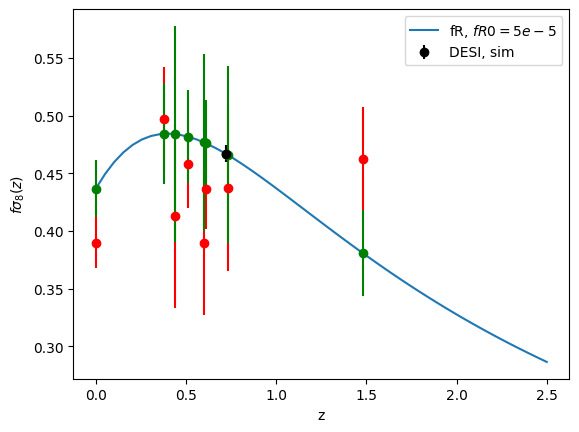

In [48]:
""" Plots: Test our fsigma8 data """

# TEST by comparing with tables in papers
print(tabulate(reducedcov_fsigma_8[:-1,:-1] * np.outer(fsigma_8_realdata*fsigma_8_fracerror[:-1], fsigma_8_realdata*fsigma_8_fracerror[:-1]), headers))

plt.plot(np.linspace(0.0, 2.5, 50), fsigma8_musigma(cosmo_universe, MGParam_universe, 1/(np.linspace(0.0, 2.5, 50)+1)), label=r"fR, $fR0 = 5e-5$")
plt.errorbar(z_eff[:-1], fsigma_8_realdata, yerr=fsigma_8_realdata*fsigma_8_fracerror[:-1], fmt="o", color="r")
plt.errorbar(z_eff, fsigma_8_data, yerr=fsigma_8_data*fsigma_8_fracerror, fmt="o", color="g")
plt.errorbar(z_eff[-1], fsigma_8_data[-1], yerr=fsigma_8_data[-1]*fsigma_8_fracerror[-1], fmt="o", color="k", label = "DESI, sim")

plt.xlabel("z")
plt.ylabel(r"$f \sigma_8(z)$")
plt.legend()

## 4c. Get covariance matrix

Note that for Y1 SRD gives area = 12.3 k deg^2 (total area on sphere = 41.253 k deg^2), so f_sky = 0.298.

Also, they define the number density following empirical results from the HSC survey (Appendix F1), finding a value of 18 arcmin^{−2} for Y1 lens sample.

Also, For Y1, the per-bin bias values that were actually used were [1.562362, 1.732963, 1.913252, 2.100644, 2.293210] (D1.1).

Also, for Y1, neff = 9.52 over the 5 bins (from plot Fig F4) (or 10 from D2.1), so 1.904 per bin

In [49]:
def cov2corr(cov):
    """
    Convert a covariance matrix into a correlation matrix
    input:
        cov: numpy.array with dim:(N,N)
    returns:
        corr: numpy.array with dim:(N,N)
    """
    sig = np.sqrt(cov.diagonal())
    return cov/np.outer(sig, sig)

In [50]:
"""Get SRD covariance matrix to compare"""

# covariance for shear bin combinations, in order: z11, z12, z13,..., z15, z22, z23,...z55

########## Get full covariance (gauss only) ##########

covfile = np.genfromtxt("/home/c2042999/PCA_project/Y1_3x2pt_clusterN_clusterWL_cov")
print(covfile.shape)

shear_SRD = np.zeros((705,705))
ell_test_SRD = np.zeros(705)

for i in range(0,covfile.shape[0]):
    shear_SRD[int(covfile[i,0]),int(covfile[i,1])] = covfile[i,8]+covfile[i,9] # non-gauss
    shear_SRD[int(covfile[i,1]),int(covfile[i,0])] = covfile[i,8]+covfile[i,9] # non-gauss
    if int(covfile[i,0]) == int(covfile[i,1]):
        ell_test_SRD[int(covfile[i,0])] = covfile[i,2]

del covfile
print(shear_SRD.shape)

########## Remodel the covariace to match our 3x2pt order ########## 
"""
SRD_compare = np.zeros((540,540))

SRD_compare[:100,:100] = shear_SRD[440:540,440:540]
SRD_compare[100:240,100:240] = shear_SRD[300:440,300:440]
SRD_compare[240:,240:] = shear_SRD[:300,:300]

SRD_compare[:100,100:240] = shear_SRD[440:540,100:240]
SRD_compare[100:240,:100] = shear_SRD[100:240,440:540]

SRD_compare[:100,240:] = shear_SRD[440:540,:300]
SRD_compare[240:,:100] = shear_SRD[:300,440:540]

SRD_compare[240:,100:240] = shear_SRD[:300,300:440]
SRD_compare[100:240,240:] = shear_SRD[300:440,:300]
"""
SRD_compare = shear_SRD[:540,:540].copy()
print(SRD_compare.shape)
########## Cut ell bins ##########
"""
for j in 15+7+5 = 27,
for i in 20,
if i > 13, remove j*20 + i th element

15 = int(len(D_mockdata)/ell_bin_num_mockdata)
27 = len(SRD_compare)/15
13 = ell_bin_num_mockdata
"""

idx = 0

bins_SRD = int(len(SRD_compare)/(len(D_mockdata)/ell_bin_num_mockdata))
print(int(len(D_mockdata)/ell_bin_num_mockdata))
print(bins_SRD)
print(ell_bin_num_mockdata)

for j in range(int(len(D_mockdata)/ell_bin_num_mockdata)):
    for i in range(bins_SRD):
        if i >= ell_bin_num_mockdata:
            #print(int(len(SRD_compare)/(len(D_mockdata)/ell_bin_num_mockdata)))
            SRD_compare = np.delete(SRD_compare, j*bins_SRD + i - idx, 0)
            SRD_compare = np.delete(SRD_compare, j*bins_SRD + i - idx, 1)
            idx += 1

print(SRD_compare.shape)


(265275, 10)
(705, 705)
(540, 540)
27
20
13
(351, 351)


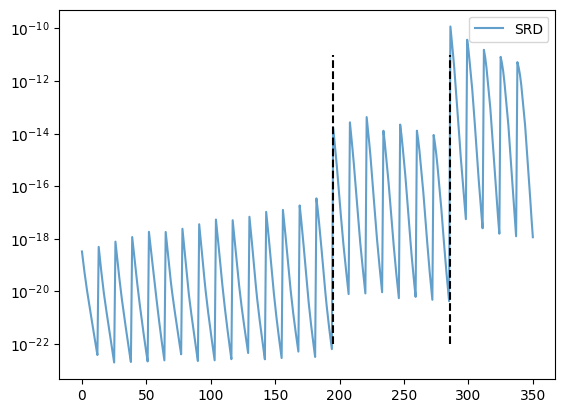

In [51]:
plt.plot(np.diag(SRD_compare), alpha = 0.7, label ="SRD")
#plt.plot(np.diag(gauss_cov_rotated), alpha = 0.7, label ="mine")
plt.plot([195,195],[1e-22,1e-11],"k--")
plt.plot([286,286],[1e-22,1e-11],"k--")
plt.yscale("log")
plt.legend()

(351, 351)


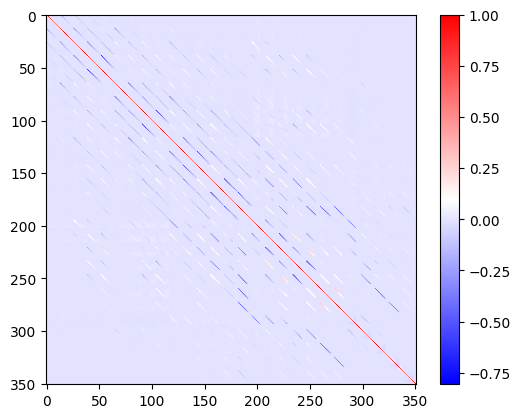

In [52]:

corr2 = cov2corr(scipy.linalg.inv(SRD_compare))
print(corr2.shape)
plt.imshow(corr2, origin='upper', cmap='bwr')

plt.colorbar()
plt.show()
#np.savetxt("/home/c2042999/PCA_project/cov_example.txt",corr2)
# kk, delk, deldel

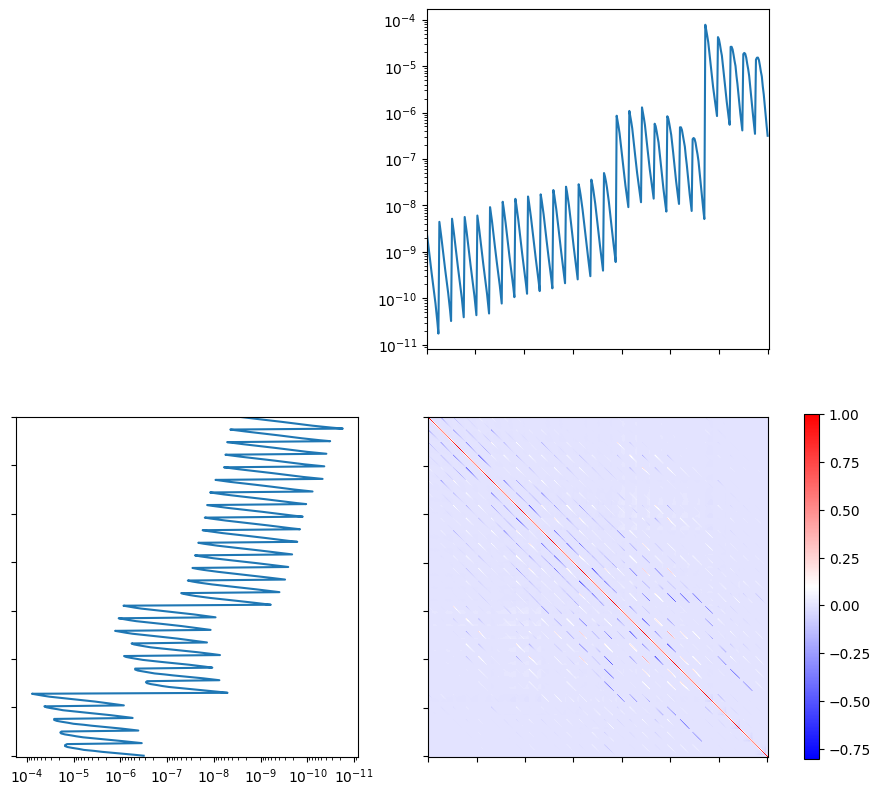

In [53]:

fig = plt.figure(figsize=(15,15))


ax = plt.subplot2grid((3, 3), (1,1))
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
corr2 = cov2corr(scipy.linalg.inv(SRD_compare))
im = plt.imshow(corr2, origin='upper', cmap='bwr')

ax = plt.subplot2grid((3, 3), (0,1))
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
plt.semilogy(np.arange(0, len(D_mockdata)), D_mockdata)
ax.set_xlim((0, len(D_mockdata)))

ax = plt.subplot2grid((3, 3), (1,0))
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_ylim((0, len(D_mockdata)))
plt.semilogx(D_mockdata,np.arange(0, len(D_mockdata)))
ax.invert_xaxis()
ax.invert_yaxis()

cbar_ax = fig.add_axes([0.65, 0.38, 0.01, 0.23])
fig.colorbar(im, shrink=0.5, cax=cbar_ax)

#plt.savefig('/home/c2042999/PCA_project/Corr_and_data_plot.pdf' , bbox_inches='tight')
fig.show()


### Cholensky, uncut

/tmp/ipykernel_2486461/4183053853.py:3: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  L_choleski_uncut = np.linalg.cholesky(np.matrix(SRD_compare))


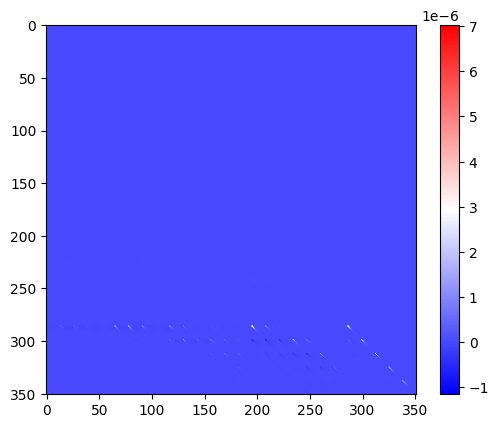

In [54]:
"""Get cholensky decomposition"""

L_choleski_uncut = np.linalg.cholesky(np.matrix(SRD_compare))
L_choleski_inv_uncut = np.linalg.inv(L_choleski_uncut)
plt.imshow(L_choleski_uncut, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

(351, 351)


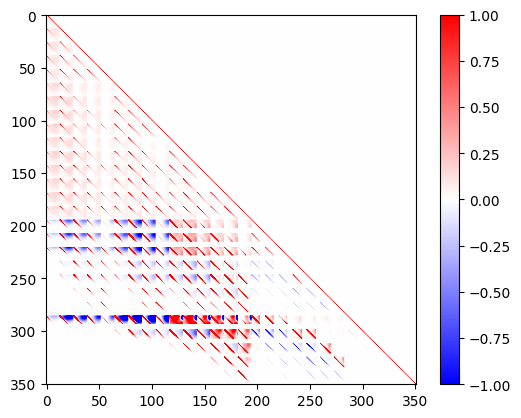

In [55]:
corr_ch = cov2corr(L_choleski_uncut)
print(corr_ch.shape)
plt.imshow(corr_ch, origin='upper', vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
#plt.savefig("/home/c2042999/PCA_project/TJPCov_ch_corr_matrix.pdf")

plt.show()

# 5. Finding PCA components

PCA conventions in Python

A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12
\end{bmatrix}$ = [[a00, a01, a02], [a10, a11, a12]], with aij = A[i][j]

A[0] is first row, A[:][0] is first column

len(A) = number of rows, len(A[0]) = number of columns

AxB = np.matmul(A,B)

for B = $\begin{bmatrix}
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$, np.append(A,B, axis = 0) = A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12\\
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$ 

In [56]:
# Perform PCA with numpy.linalg.svd - find rotation matrix
def findPCA(M_data, B_data, L_ch_inv):
    Delta = np.array(np.matmul(L_ch_inv, (B_data - M_data).T).T)
    Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)
    Usvd = Usvd.T
    return Usvd

def findPCA_plots(M_data, B_data):
    Delta = (B_data - M_data)
    Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)
    Usvd = Usvd.T
    return Usvd

## 5a. tests - data space

In [81]:
col = sns.color_palette("colorblind")

In [82]:
n_idx = 12
ell_bin_number = 13
diff = 6 # for unweighted use 4
B1 = np.append(np.append(D_testdata_kk[n_idx-2*diff], D_testdata_kk[n_idx-diff]), D_testdata_kk[n_idx])
B2 = np.append(np.append(D_testdata_kk_fR[n_idx-2*diff], D_testdata_kk_fR[n_idx-diff]), D_testdata_kk_fR[n_idx])
B3 = np.append(np.append(D_testdata_GR_kk[n_idx-2*diff], D_testdata_GR_kk[n_idx-diff]), D_testdata_GR_kk[n_idx])

M1 = np.append(np.append(D_testdata_lin_kk[n_idx-2*diff], D_testdata_lin_kk[n_idx-diff]), D_testdata_lin_kk[n_idx])
M2 = np.append(np.append(D_testdata_lin_kk_fR[n_idx-2*diff], D_testdata_lin_kk_fR[n_idx-diff]), D_testdata_lin_kk_fR[n_idx])
M3 = np.append(np.append(D_testdata_GR_lin_kk[n_idx-2*diff], D_testdata_GR_lin_kk[n_idx-diff]), D_testdata_GR_lin_kk[n_idx])


In [84]:
print(B1,B2,B3,M1,M2,M3)

[3.58005077e-09 3.46217092e-10 1.81463013e-11] [2.51252772e-09 2.53409521e-10 1.91187634e-11] [2.42744770e-09 2.22989941e-10 1.58791546e-11] [3.32722017e-09 1.13068975e-10 1.12951988e-12] [2.44566404e-09 1.00060689e-10 1.26555053e-12] [2.31225342e-09 7.88591793e-11 7.88944003e-13]


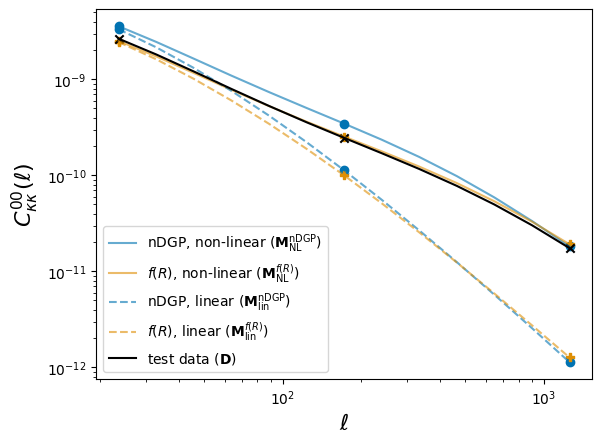

In [59]:
"""Plots: Test C_kk(ell) function"""


for j in range(1):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_kk[j*ell_bin_number:(j+1)*ell_bin_number], color=col[0], alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_kk_fR[j*ell_bin_number:(j+1)*ell_bin_number], color=col[1], alpha= 0.6)

    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_lin_kk[j*ell_bin_number:(j+1)*ell_bin_number], color=col[0], linestyle="--", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_lin_kk_fR[j*ell_bin_number:(j+1)*ell_bin_number], color=col[1],linestyle="--", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_kk_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], "k")

    plt.scatter(ell_testdata[n_idx-2*diff],D_testdata_kk[n_idx-2*diff], color=col[0])
    plt.scatter(ell_testdata[n_idx-diff],D_testdata_kk[n_idx-diff], color=col[0])
    plt.scatter(ell_testdata[n_idx],D_testdata_kk[n_idx], color=col[0])

    plt.scatter(ell_testdata[n_idx-2*diff],D_testdata_kk_fR[n_idx-2*diff], color=col[1], marker="P")
    plt.scatter(ell_testdata[n_idx-diff],D_testdata_kk_fR[n_idx-diff], color=col[1], marker="P")
    plt.scatter(ell_testdata[n_idx],D_testdata_kk_fR[n_idx], color=col[1], marker="P")
    
    plt.scatter(ell_testdata[n_idx-2*diff],D_testdata_lin_kk[n_idx-2*diff], color=col[0])
    plt.scatter(ell_testdata[n_idx-diff],D_testdata_lin_kk[n_idx-diff], color=col[0])
    plt.scatter(ell_testdata[n_idx],D_testdata_lin_kk[n_idx], color=col[0])
    
    plt.scatter(ell_testdata[n_idx-2*diff],D_testdata_lin_kk_fR[n_idx-2*diff], color=col[1], marker="P")
    plt.scatter(ell_testdata[n_idx-diff],D_testdata_lin_kk_fR[n_idx-diff], color=col[1], marker="P")
    plt.scatter(ell_testdata[n_idx],D_testdata_lin_kk_fR[n_idx], color=col[1], marker="P")
    
    plt.scatter(ell_testdata[n_idx-2*diff],D_kk_mockdata[n_idx-2*diff], color="k", marker="x")
    plt.scatter(ell_testdata[n_idx-diff],D_kk_mockdata[n_idx-diff], color="k", marker="x")
    plt.scatter(ell_testdata[n_idx],D_kk_mockdata[n_idx], color="k", marker="x")

plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$C^{00}_{\kappa \kappa}(\ell)$', fontsize=16)
plt.legend([r"nDGP, non-linear $(\mathbf{M}^{\text{nDGP}}_{\text{NL}})$", r"$f(R)$, non-linear $(\mathbf{M}^{f(R)}_{\text{NL}})$",r"nDGP, linear $(\mathbf{M}^{\text{nDGP}}_{\text{lin}})$", r"$f(R)$, linear $(\mathbf{M}^{f(R)}_{\text{lin}})$", r"test data $(\mathbf{D})$"])#,bbox_to_anchor=(1.0, 1.0))
plt.xscale('log')
plt.yscale('log')
#plt.savefig('Figures/Cell_example.pdf' , bbox_inches='tight')
plt.show()

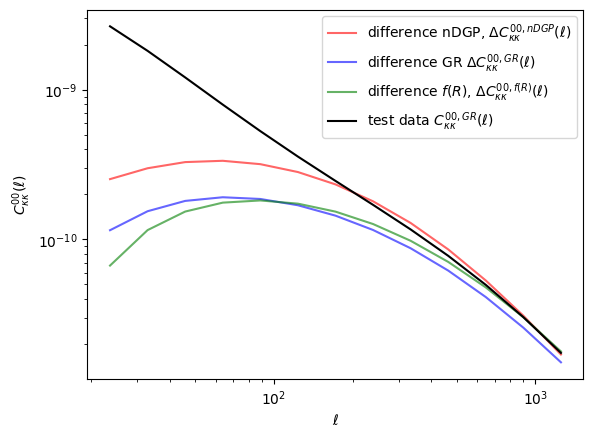

In [60]:
"""Plots: Test C_kk(ell) function"""


for j in range(1):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], (D_testdata_kk-D_testdata_lin_kk)[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], (D_testdata_GR_kk - D_testdata_GR_lin_kk)[j*ell_bin_number:(j+1)*ell_bin_number], "b", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], (D_testdata_kk_fR - D_testdata_lin_kk_fR)[j*ell_bin_number:(j+1)*ell_bin_number], "g", alpha= 0.6)

    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_kk_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], "k")


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C^{00}_{\kappa \kappa}(\ell)$')
plt.legend([r"difference nDGP, $\Delta C^{00, nDGP}_{\kappa\kappa}(\ell)$", r"difference GR $\Delta C^{00, GR}_{\kappa\kappa}(\ell)$", r"difference $f(R)$, $\Delta C^{00, f(R)}_{\kappa\kappa}(\ell)$", r"test data $C^{00, GR}_{\kappa\kappa}(\ell)$"],bbox_to_anchor=(1.0, 1.0))
plt.xscale('log')
plt.yscale('log')

plt.show()

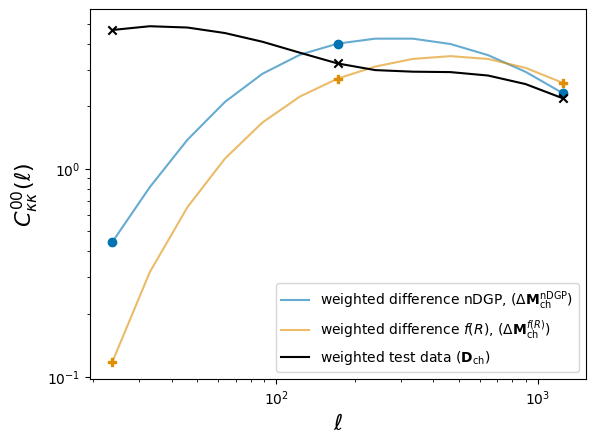

In [61]:
"""Plots: Test C_kk(ell) function"""

nDGP_weighted_data = np.array(np.matmul(np.linalg.inv(L_choleski_uncut[:195,:195]), (D_testdata_kk-D_testdata_lin_kk).T).T)
GR_weighted_data = np.array(np.matmul(np.linalg.inv(L_choleski_uncut[:195,:195]), (D_testdata_GR_kk - D_testdata_GR_lin_kk).T).T)
fR_weighted_data = np.array(np.matmul(np.linalg.inv(L_choleski_uncut[:195,:195]), (D_testdata_kk_fR - D_testdata_lin_kk_fR).T).T)

weighted_testdata = np.array(np.matmul(np.linalg.inv(L_choleski_uncut[:195,:195]), D_kk_mockdata.T).T)


for j in range(1):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], nDGP_weighted_data[j*ell_bin_number:(j+1)*ell_bin_number], color=col[0], alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], fR_weighted_data[j*ell_bin_number:(j+1)*ell_bin_number], color=col[1], alpha= 0.6)

    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number],weighted_testdata[j*ell_bin_number:(j+1)*ell_bin_number], "k")

    plt.scatter(ell_testdata[n_idx-2*diff],nDGP_weighted_data[n_idx-2*diff], color=col[0])
    plt.scatter(ell_testdata[n_idx-diff],nDGP_weighted_data[n_idx-diff], color=col[0])
    plt.scatter(ell_testdata[n_idx],nDGP_weighted_data[n_idx], color=col[0])

    plt.scatter(ell_testdata[n_idx-2*diff],fR_weighted_data[n_idx-2*diff], color=col[1], marker="P")
    plt.scatter(ell_testdata[n_idx-diff],fR_weighted_data[n_idx-diff], color=col[1], marker="P")
    plt.scatter(ell_testdata[n_idx],fR_weighted_data[n_idx], color=col[1], marker="P")
    
    plt.scatter(ell_testdata[n_idx-2*diff],weighted_testdata[n_idx-2*diff], color="k", marker="x")
    plt.scatter(ell_testdata[n_idx-diff],weighted_testdata[n_idx-diff], color="k", marker="x")
    plt.scatter(ell_testdata[n_idx],weighted_testdata[n_idx], color="k", marker="x")

plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$C^{00}_{\kappa \kappa}(\ell)$', fontsize=16)
plt.legend([r"weighted difference nDGP, $(\Delta\mathbf{M}^{\text{nDGP}}_{\text{ch}})$", r"weighted difference $f(R)$, $(\Delta\mathbf{M}^{f(R)}_{\text{ch}})$", r"weighted test data $(\mathbf{D}_{\text{ch}})$"])#,bbox_to_anchor=(1.0, 1.0))
plt.xscale('log')
plt.yscale('log')
#plt.savefig('Figures/Cell_weighted_example.pdf' , bbox_inches='tight')
plt.show()

In [62]:
B1_weighted = np.array(np.matmul(np.linalg.inv(L_choleski_uncut[:195,:195]), (D_testdata_kk).T).T)
B1_weighted = np.append(np.append(B1_weighted[n_idx-2*diff], B1_weighted[n_idx-diff]), B1_weighted[n_idx])

M1_weighted = np.array(np.matmul(np.linalg.inv(L_choleski_uncut[:195,:195]), (D_testdata_lin_kk).T).T)
M1_weighted = np.append(np.append(M1_weighted[n_idx-2*diff], M1_weighted[n_idx-diff]), M1_weighted[n_idx])

B3_weighted = np.array(np.matmul(np.linalg.inv(L_choleski_uncut[:195,:195]), (D_testdata_kk_fR).T).T)
B3_weighted = np.append(np.append(B3_weighted[n_idx-2*diff], B3_weighted[n_idx-diff]), B3_weighted[n_idx])

M3_weighted = np.array(np.matmul(np.linalg.inv(L_choleski_uncut[:195,:195]), (D_testdata_lin_kk_fR).T).T)
M3_weighted = np.append(np.append(M3_weighted[n_idx-2*diff], M3_weighted[n_idx-diff]), M3_weighted[n_idx])


B_data =np.array([B1_weighted,B3_weighted])
M_data =np.array([M1_weighted, M3_weighted])
print(np.array(np.matmul(np.linalg.inv(L_choleski_uncut[:195,:195]), (D_testdata_kk).T).T).shape)
print(B1.shape)
print(D_kk_mockdata.shape, D_delk_mockdata.shape, D_deldel_mockdata.shape)
print(D_testdata_kk.shape, D_testdata_delk.shape, D_testdata_deldel.shape)
Delta = (B_data - M_data)#np.array(np.matmul(L_choleski_inv,(B_data - M_data).T).T)

U_plotting = findPCA_plots(M_data, B_data)

Mockdata_test = np.array(np.matmul(np.linalg.inv(L_choleski_uncut[:195,:195]), D_kk_mockdata.T).T)
Mockdata_test = np.append(np.append(Mockdata_test[n_idx-2*diff], Mockdata_test[n_idx-diff]), Mockdata_test[n_idx])

#Mockdata_test = np.append(np.append(D_kk_mockdata[n_idx-2*diff], D_kk_mockdata[n_idx-diff]), D_kk_mockdata[n_idx])
print(Delta.shape)
print(U_plotting.shape)

(195, 1)
(3,)
(195,) (91,) (65,)
(195,) (91,) (65,)
(2, 3)
(3, 3)


In [63]:
# Show U matrix is orthogonal
print(np.allclose(np.eye(len(U_plotting)), U_plotting.dot(U_plotting.T.conj())))
print(np.dot(U_plotting[0], U_plotting[1])/np.sqrt(np.dot(U_plotting[0],U_plotting[0]))\
                                            /np.sqrt(np.dot(U_plotting[1],U_plotting[1])))
print(np.dot(U_plotting[2], U_plotting[1])/np.sqrt(np.dot(U_plotting[2],U_plotting[2]))\
                                            /np.sqrt(np.dot(U_plotting[1],U_plotting[1])))
print(np.dot(U_plotting[0], U_plotting[2])/np.sqrt(np.dot(U_plotting[0],U_plotting[0]))\
                                            /np.sqrt(np.dot(U_plotting[2],U_plotting[2])))

# Show non-eigenvector is orthogonal to difference vectors
print(np.dot(Delta[0], U_plotting[2])/np.sqrt(np.dot(Delta[0],Delta[0]))\
                                            /np.sqrt(np.dot(U_plotting[2],U_plotting[2])))
print(np.dot(Delta[1], U_plotting[2])/np.sqrt(np.dot(Delta[1],Delta[1]))\
                                            /np.sqrt(np.dot(U_plotting[2],U_plotting[2])))

True
1.3883183781597453e-16
8.559117416905027e-17
1.9399446006701036e-16
-1.41416365520241e-16
-1.1879305375758852e-16


In [64]:
print(U_plotting)
print(Mockdata_test)
print(Delta)

[[-0.07072    -0.81367976 -0.57699561]
 [-0.25996732 -0.54341916  0.79819334]
 [-0.96302423  0.20644823 -0.17309954]]
[4.65416242 3.21226384 2.18093511]
[[0.44338643 4.00267258 2.30707025]
 [0.11725815 2.71659617 2.58760959]]


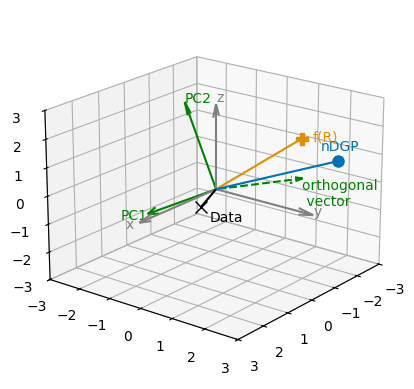

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting vectors as lines without arrowheads
ax.quiver(0, 0, 0, Mockdata_test[0], Mockdata_test[1], Mockdata_test[2], color="k", arrow_length_ratio=0)
ax.quiver(0, 0, 0, 3, 0, 0, color="gray", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 3, 0, color="gray", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 0, 3, color="gray", arrow_length_ratio=0.15)

ax.quiver(0, 0, 0, Delta[0][0], Delta[0][1], Delta[0][2], color=col[0], arrow_length_ratio=0)
ax.quiver(0, 0, 0, Delta[1][0], Delta[1][1], Delta[1][2], color=col[1], arrow_length_ratio=0)

ax.quiver(0, 0, 0, 3*U_plotting[0][0], 3*U_plotting[0][1], 3*U_plotting[0][2], color="g", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 3*U_plotting[1][0], 3*U_plotting[1][1], 3*U_plotting[1][2], color="g", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 3*U_plotting[2][0], 3*U_plotting[2][1], 3*U_plotting[2][2], color="g", linestyle="--", arrow_length_ratio=0.15)

# Adding cross-shaped markers at the end of each vector
end_points = [
    (Mockdata_test[0], Mockdata_test[1], Mockdata_test[2]),
    (3, 0, 0),
    (0, 3, 0),
    (0, 0, 3),
    (Delta[0][0], Delta[0][1], Delta[0][2]),
    (Delta[1][0], Delta[1][1], Delta[1][2]),
    (3*U_plotting[0][0], 3*U_plotting[0][1], 3*U_plotting[0][2]),
    (3*U_plotting[1][0], 3*U_plotting[1][1], 3*U_plotting[1][2]),
    (3*U_plotting[2][0], 3*U_plotting[2][1], 3*U_plotting[2][2])
]

# Colors for the cross markers (same as the vectors)
colors = ["k", "gray", "gray", "gray", col[0], col[1], "g", "g", "g"]
markers = ["x",None,None,None, "o","P", None,None,None]

# Plotting crosses at each vector end point
for (x, y, z), color, mark in zip(end_points, colors, markers):
    ax.plot([x], [y], [z], marker=mark, markersize=8, color=color)

# Adding labels
labels = ["Data", "x", "y", "z", "nDGP", "f(R)", 
          "PC1", "PC2", "orthogonal \n vector"]

# Coordinates for each vector's label
coordinates = [
    (Mockdata_test[0] +0.6, Mockdata_test[1]+0.7, Mockdata_test[2]),
    (3 + 0.5, 0, 0),
    (0, 3, 0),
    (0, 0, 3 + 0.1),
    (Delta[0][0], Delta[0][1] - 0.5, Delta[0][2]+0.2),
    (Delta[1][0], Delta[1][1]+0.3, Delta[1][2]),
    (3*U_plotting[0][0] + 1.2, 3*U_plotting[0][1]+0.1, 3*U_plotting[0][2] + 0.3),
    (3*U_plotting[1][0], 3*U_plotting[1][1], 3*U_plotting[1][2]),
    (3*U_plotting[2][0], 3*U_plotting[2][1], 3*U_plotting[2][2]-1)
]

# Adding text labels to the plot
for i, (x, y, z) in enumerate(coordinates):
    ax.text(x, y, z, labels[i], color=colors[i])

# Set axis limits
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

ax.view_init(elev=20, azim=38, roll=0)
#plt.savefig('Figures/PCs_dataspace.pdf' , bbox_inches='tight')

# Show plot
plt.draw()
plt.show()


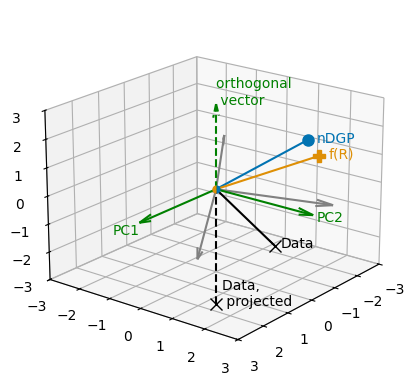

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

# Normalization function
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        norm = np.finfo(v.dtype).eps
    return v / norm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the vectors with labels

# Mockdata_test vector
vec1 = np.matmul(U_plotting, Mockdata_test).T
ax.quiver(0, 0, 0, vec1[0], vec1[1], vec1[2], color="k", arrow_length_ratio=0)
ax.quiver(0, 0, 0, 0, 0, vec1[2], color="k", linestyle="--", arrow_length_ratio=0)

# Rotated axis vectors
rot_xaxis = normalize(np.matmul(U_plotting, np.array([1, 0, 0])).T) * 3
rot_yaxis = normalize(np.matmul(U_plotting, np.array([0, 1, 0])).T) * 3
rot_zaxis = normalize(np.matmul(U_plotting, np.array([0, 0, 1])).T) * 3

ax.quiver(0, 0, 0, rot_xaxis[0], rot_xaxis[1], rot_xaxis[2], color="gray", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, rot_yaxis[0], rot_yaxis[1], rot_yaxis[2], color="gray", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, rot_zaxis[0], rot_zaxis[1], rot_zaxis[2], color="gray", arrow_length_ratio=0.15)

# Unit vectors in green
ax.quiver(0, 0, 0, 3, 0, 0, color="g", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 3, 0, color="g", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 0, 3, color="g", linestyle="--", arrow_length_ratio=0.15)

# Delta vectors
vec5 = np.matmul(U_plotting, Delta[0]).T
vec6 = np.matmul(U_plotting, Delta[1]).T

ax.quiver(0, 0, 0, vec5[0], vec5[1], vec5[2], color=col[0], arrow_length_ratio=0)
ax.quiver(0, 0, 0, vec6[0], vec6[1], vec6[2], color=col[1], arrow_length_ratio=0)

# Adding custom markers at vector endpoints
end_points = [
    (vec1[0], vec1[1], vec1[2]),
    (0, 0 , vec1[2]),
    (rot_xaxis[0], rot_xaxis[1], rot_xaxis[2]),
    (rot_yaxis[0], rot_yaxis[1], rot_yaxis[2]),
    (rot_zaxis[0], rot_zaxis[1], rot_zaxis[2]),
    (vec5[0], vec5[1], vec5[2]),
    (vec6[0], vec6[1], vec6[2]),
    (3, 0, 0),
    (0, 3, 0),
    (0, 0, 3)
]

# Colors and markers for the endpoints
colors = ["k", "k","gray", "gray", "gray", col[0], col[1], "g", "g", "g"]
markers = ["x","x", None, None, None, "o", "P", None, None, None]
fill_mark = ["k", 'none',"gray", "gray", "gray", col[0], col[1], "g", "g", "g"]

for (x, y, z), color, mark, fill in zip(end_points, colors, markers,fill_mark):
    ax.plot([x], [y], [z], marker=mark, markersize=8, color=color, mfc = fill)

# Adding labels
labels = ["Data", "Data, \n projected", None, None, None, "nDGP", "f(R)", 
          "PC1", "PC2", "orthogonal \n vector"]

# Coordinates for each vector's label
coordinates = [
    (vec1[0], vec1[1]+0.2, vec1[2]),
    (0, 0 + 0.2, vec1[2]),
    (rot_xaxis[0] + 0.8, rot_xaxis[1] + 0.1, rot_xaxis[2]),
    (rot_yaxis[0] + 0.5, rot_yaxis[1], rot_yaxis[2] + 0.4),
    (rot_zaxis[0], rot_zaxis[1], rot_zaxis[2]),
    (vec5[0], vec5[1]+0.3, vec5[2]),
    (vec6[0], vec6[1]+0.3, vec6[2]),
    (3 + 1, 0, 0),
    (0, 3 + 0.1, 0 -0.2),
    (0, 0, 3)
]

# Adding text labels to the plot
for i, (x, y, z) in enumerate(coordinates):
    ax.text(x, y, z, labels[i], color=colors[i])

# Central dot
ax.plot(0,0,vec5[2], color="none",mew=0.0, mfc = col[0], marker=matplotlib.markers.MarkerStyle("o", fillstyle="right"),\
        zorder=12)
ax.plot(0,0,vec6[2], color="none",mew=0.0, mfc = col[1],marker=matplotlib.markers.MarkerStyle("o", fillstyle="left"),\
        zorder=13)


# Set axis limits
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

# Update the axis view and title
ax.view_init(elev=20, azim=38, roll=0)

#plt.savefig('Figures/PCs_dataspace_rotated.pdf' , bbox_inches='tight')

# Show plot
plt.draw()
plt.show()


## 5 a. tests - ell space

In [67]:
B1 = np.append(np.append(D_testdata_kk, D_testdata_delk), D_testdata_deldel)
B2 = np.append(np.append(D_testdata_kk_fR, D_testdata_delk_fR), D_testdata_deldel_fR)
B3 = np.append(np.append(D_testdata_GR_kk, D_testdata_GR_delk), D_testdata_GR_deldel)

M1 = np.append(np.append(D_testdata_lin_kk, D_testdata_lin_delk), D_testdata_lin_deldel)
M2 = np.append(np.append(D_testdata_lin_kk_fR, D_testdata_lin_delk_fR), D_testdata_lin_deldel_fR)
M3 = np.append(np.append(D_testdata_GR_lin_kk, D_testdata_GR_lin_delk), D_testdata_GR_lin_deldel)

In [68]:
B_data =np.array([B1,B2,B3])
M_data =np.array([M1,M2,M3])
print(Delta.shape)
print(L_choleski_inv_uncut.shape)

(2, 3)
(351, 351)


In [69]:
print(L_choleski_inv_uncut.shape)
print(B_data.shape)
Delta = np.array(np.matmul(L_choleski_inv_uncut,(B_data - M_data).T).T)

#TEST: Perform PCA with numpy.linalg.svd

Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)

Usvd = Usvd.T

print("eigenvalues = ", s)

print("shape U = ", Usvd.shape)
print("shape sigma = ", s.shape)
print("shape V_transpose = ", vh.shape)


(351, 351)
(3, 351)
eigenvalues =  [1523.50379071   63.99758311   15.2352324 ]
shape U =  (351, 351)
shape sigma =  (3,)
shape V_transpose =  (3, 3)


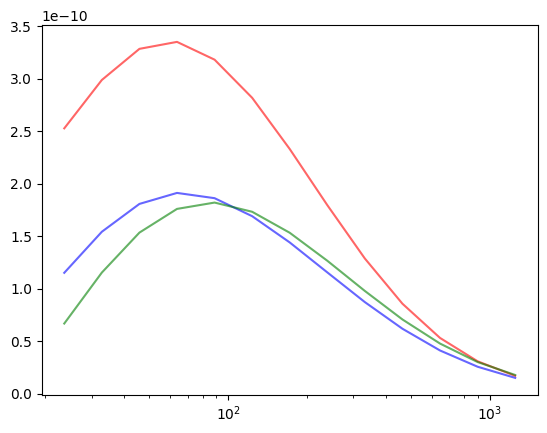

In [70]:
for j in range(1):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], (D_testdata_kk-D_testdata_lin_kk)[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], (D_testdata_GR_kk-D_testdata_GR_lin_kk)[j*ell_bin_number:(j+1)*ell_bin_number], "b", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], (D_testdata_kk_fR-D_testdata_lin_kk_fR)[j*ell_bin_number:(j+1)*ell_bin_number], "g", alpha= 0.6)

plt.xscale("log")


13 23.599705605743537 1252.9817318061569


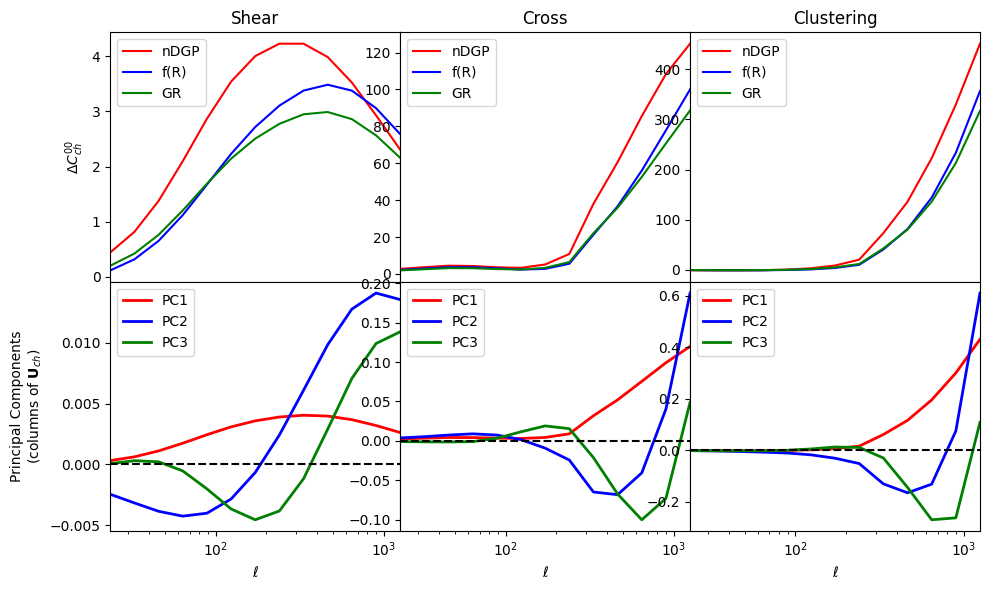

In [71]:
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, sharex=True, figsize=(10, 6))
print(ell_bin_number, ell_testdata[0], ell_testdata[ell_bin_number-1])
# Plot on each subplot
for i in range(3):
    axs[0, 0].plot(ell_testdata[0:ell_bin_number], Delta[i][0:ell_bin_number], color=["r","b","g"][i], label=['nDGP','f(R)','GR'][i])
    axs[0, 1].plot(ell_testdata[0:ell_bin_number], Delta[i][195:195+ell_bin_number], color=["r","b","g"][i], label=['nDGP','f(R)','GR'][i])
    axs[0, 2].plot(ell_testdata[0:ell_bin_number], Delta[i][195+91:195+91+ell_bin_number], color=["r","b","g"][i], label=['nDGP','f(R)','GR'][i])

axs[0, 0].set_title('Shear')
axs[0, 1].set_title('Cross')
axs[0, 2].set_title('Clustering')

for i in range(3):
    axs[1, 0].plot(ell_testdata[0:ell_bin_number], -Usvd[i][0: ell_bin_number], linewidth=2, color=["r","b","g"][i], label=['PC1','PC2','PC3'][i])
    axs[1, 1].plot(ell_testdata[0:ell_bin_number], -Usvd[i][195:195+ell_bin_number], linewidth=2, color=["r","b","g"][i], label=['PC1','PC2','PC3'][i])
    axs[1, 2].plot(ell_testdata[0:ell_bin_number], -Usvd[i][195+91:195+91+ell_bin_number], linewidth=2, color=["r","b","g"][i], label=['PC1','PC2','PC3'][i])

axs[1, 0].plot(ell_testdata[0:ell_bin_number], np.zeros(len(ell_testdata[0:ell_bin_number])), "k--")
axs[1, 1].plot(ell_testdata[0:ell_bin_number], np.zeros(len(ell_testdata[0:ell_bin_number])), "k--")
axs[1, 2].plot(ell_testdata[0:ell_bin_number], np.zeros(len(ell_testdata[0:ell_bin_number])), "k--")

axs[1, 0].set_xlabel(r'$\ell$')
axs[1, 1].set_xlabel(r'$\ell$')
axs[1, 2].set_xlabel(r'$\ell$')
axs[1, 0].set_xlim(ell_testdata[0], ell_testdata[ell_bin_number-1])
axs[1, 1].set_xlim(ell_testdata[0], ell_testdata[ell_bin_number-1])
axs[1, 2].set_xlim(ell_testdata[0], ell_testdata[ell_bin_number-1])

axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 2].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[1, 2].legend()

axs[0, 0].set_ylabel(r'$\Delta C^{00}_{ch}$')
axs[1, 0].set_ylabel('Principal Components' +'\n' +r'(columns of $\mathbf{U}_{ch})$')


"""
axs[1, 0].set_ylim(-0.03, 0.03)
axs[1, 1].set_ylim(-0.03, 0.03)
axs[1, 2].set_ylim(-0.03, 0.03)
axs[1, 1].tick_params(labelleft=False, length=0)
axs[1, 2].tick_params(labelleft=False, length=0)
"""
"""
for i in range(len(Usvd)-3):
    #ax1.plot(ell[0:ell_bin_num], Umanual[i][0:ell_bin_num], color = "b", label = "Manual method")
    ax1.plot(ell_testdata[0:ell_bin_number], -Usvd[i+3][0: ell_bin_number], "k--", alpha=0.01)
    #ax1.plot(ell[0:ell_bin_num], Usklearn[i,0:ell_bin_num], label = "sklearn method", color = "y")
    #ax1.plot(ell[0:ell_bin_number], PCAs_vects_sklearn[i,0:ell_bin_number], color = "y",linewidth=2+i/2)
"""

# Add x-axis label shared across all subplots
for ax in axs.flat:
    ax.set_xscale("log")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('PCs_ellspace.pdf' , bbox_inches='tight')

# Display the plot
plt.show()

### Manim

In [72]:
B1 = np.append(np.append(D_testdata_kk, D_testdata_delk), D_testdata_deldel)
B2 = np.append(np.append(D_testdata_kk_fR, D_testdata_delk_fR), D_testdata_deldel_fR)
B3 = np.append(np.append(D_testdata_GR_kk, D_testdata_GR_delk), D_testdata_GR_deldel)

M1 = np.append(np.append(D_testdata_lin_kk, D_testdata_lin_delk), D_testdata_lin_deldel)
M2 = np.append(np.append(D_testdata_lin_kk_fR, D_testdata_lin_delk_fR), D_testdata_lin_deldel_fR)
M3 = np.append(np.append(D_testdata_GR_lin_kk, D_testdata_GR_lin_delk), D_testdata_GR_lin_deldel)

Mockdata = np.append(np.append(D_kk_mockdata, D_delk_mockdata), D_deldel_mockdata)

np.savez("/home/c2042999/PCA_project/Visualizing_PCAs/manim_data.npz",
             B1_val=B1,
             B2_val=B2,
             B3_val=B3,
             M1_val=M1,
             M2_val=M2,
             M3_val=M3,
             Mockdata_val = Mockdata,
             ell=ell_testdata,
             L_ch = L_choleski_uncut)

## Old code

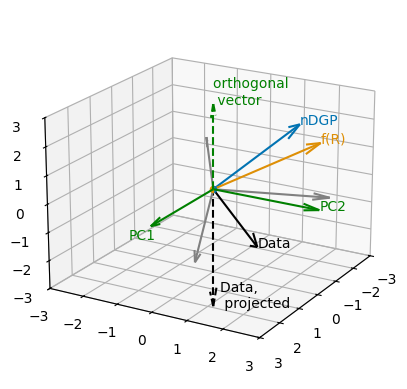

In [106]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        norm = np.finfo(v.dtype).eps
    return v / norm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the vectors with labels

# Mockdata_test vector
vec1 = np.matmul(U_plotting, Mockdata_test).T
ax.quiver(0, 0, 0, vec1[0], vec1[1], vec1[2], color="k", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 0, vec1[2], color="k", linestyle="--", arrow_length_ratio=0.15)

# Rotated axis vectors
rot_xaxis = normalize(np.matmul(U_plotting, np.array([1, 0, 0])).T) * 3
rot_yaxis = normalize(np.matmul(U_plotting, np.array([0, 1, 0])).T) * 3
rot_zaxis = normalize(np.matmul(U_plotting, np.array([0, 0, 1])).T) * 3

ax.quiver(0, 0, 0, rot_xaxis[0], rot_xaxis[1], rot_xaxis[2], color="gray", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, rot_yaxis[0], rot_yaxis[1], rot_yaxis[2], color="gray", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, rot_zaxis[0], rot_zaxis[1], rot_zaxis[2], color="gray", arrow_length_ratio=0.15)

# Unit vectors in green
ax.quiver(0, 0, 0, 3, 0, 0, color="g", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 3, 0, color="g", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 0, 3, color="g", linestyle="--", arrow_length_ratio=0.15)

# Delta vectors
vec5 = np.matmul(U_plotting, Delta[0]).T
vec6 = np.matmul(U_plotting, Delta[1]).T

ax.quiver(0, 0, 0, vec5[0], vec5[1], vec5[2], color=col[0], arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, vec6[0], vec6[1], vec6[2], color=col[1], arrow_length_ratio=0.15)

# Central dot
ax.scatter(0,0,vec5[2], color=col[0], marker=matplotlib.markers.MarkerStyle("o", fillstyle="right"))
ax.scatter(0,0,vec5[2], color=col[1], marker=matplotlib.markers.MarkerStyle("o", fillstyle="left"))

# Adding labels
labels = ["Data", "Data, \n projected", None, None, None, "nDGP", "f(R)", 
          "PC1", "PC2", "orthogonal \n vector"]

# Coordinates for each vector's label
coordinates = [
    (vec1[0], vec1[1], vec1[2]),
    (0, 0+0.2, vec1[2]),
    (rot_xaxis[0]+0.8, rot_xaxis[1]+0.1, rot_xaxis[2]),
    (rot_yaxis[0]+0.5, rot_yaxis[1], rot_yaxis[2]+0.4),
    (rot_zaxis[0], rot_zaxis[1], rot_zaxis[2]),
    (vec5[0], vec5[1], vec5[2]),
    (vec6[0], vec6[1], vec6[2]),
    (3+1, 0, 0),
    (0, 3, 0),
    (0, 0, 3)
]

# Colors for the labels (same as the vectors)
colors = ["k", "k", "gray", "gray", "gray", col[0], col[1], "g", "g", "g"]

# Adding text labels to the plot
for i, (x, y, z) in enumerate(coordinates):
    ax.text(x, y, z, labels[i], color=colors[i])

# Set axis limits
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

# Update the axis view and title
ax.view_init(elev=20, azim=30, roll=0)

#plt.savefig('Figures/PCs_dataspace_rotated.pdf' , bbox_inches='tight')
plt.draw()
plt.show()

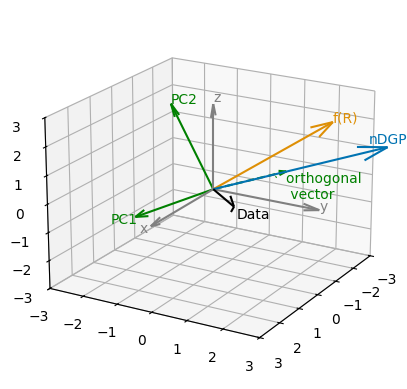

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting vectors
ax.quiver(0, 0, 0, Mockdata_test[0], Mockdata_test[1], Mockdata_test[2], color="k", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 3, 0, 0, color="gray", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 3, 0, color="gray", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 0, 3, color="gray", arrow_length_ratio=0.15)

ax.quiver(0, 0, 0, Delta[0][0], Delta[0][1], Delta[0][2], color=col[0], arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, Delta[1][0], Delta[1][1], Delta[1][2], color=col[1], arrow_length_ratio=0.15)
# ax.quiver(0, 0, 0, Delta[2][0], Delta[2][1], Delta[2][2])

ax.quiver(0, 0, 0, 3*U_plotting[0][0], 3*U_plotting[0][1], 3*U_plotting[0][2], color="g", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 3*U_plotting[1][0], 3*U_plotting[1][1], 3*U_plotting[1][2], color="g", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 3*U_plotting[2][0], 3*U_plotting[2][1], 3*U_plotting[2][2], color="g", linestyle="--", arrow_length_ratio=0.15)

# Adding labels
labels = ["Data", "x", "y", "z", "nDGP", "f(R)", 
          "PC1", "PC2", "orthogonal \n vector"]

# Coordinates for each vector's label
coordinates = [
    (Mockdata_test[0] +0.6, Mockdata_test[1]+0.4, Mockdata_test[2]),
    (3 + 0.5, 0, 0),
    (0, 3, 0),
    (0, 0, 3 + 0.1),
    (Delta[0][0], Delta[0][1] - 0.5, Delta[0][2]),
    (Delta[1][0], Delta[1][1], Delta[1][2]),
    (3*U_plotting[0][0] + 1.2, 3*U_plotting[0][1], 3*U_plotting[0][2] + 0.3),
    (3*U_plotting[1][0], 3*U_plotting[1][1], 3*U_plotting[1][2]),
    (3*U_plotting[2][0], 3*U_plotting[2][1], 3*U_plotting[2][2]-1)
]

# Colors for the labels (same as the vectors)
colors = ["k", "gray", "gray", "gray", col[0], col[1], "g", "g", "g"]

# Adding text labels to the plot
for i, (x, y, z) in enumerate(coordinates):
    ax.text(x, y, z, labels[i], color=colors[i])

# Set axis limits
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

ax.view_init(elev=20, azim=30, roll=0)

#plt.savefig('Figures/PCs_dataspace.pdf' , bbox_inches='tight')


plt.draw()
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting vectors
ax.quiver(0, 0, 0, Mockdata_test[0], Mockdata_test[1], Mockdata_test[2], color="k", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 3, 0, 0, color="gray", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 3, 0, color="gray", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 0, 0, 3, color="gray", arrow_length_ratio=0.15)

ax.quiver(0, 0, 0, Delta[0][0], Delta[0][1], Delta[0][2], color=col[0], arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, Delta[1][0], Delta[1][1], Delta[1][2], color=col[1], arrow_length_ratio=0.15)
# ax.quiver(0, 0, 0, Delta[2][0], Delta[2][1], Delta[2][2])

ax.quiver(0, 0, 0, 3*U_plotting[0][0], 3*U_plotting[0][1], 3*U_plotting[0][2], color="g", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 3*U_plotting[1][0], 3*U_plotting[1][1], 3*U_plotting[1][2], color="g", arrow_length_ratio=0.15)
ax.quiver(0, 0, 0, 3*U_plotting[2][0], 3*U_plotting[2][1], 3*U_plotting[2][2], color="g", linestyle="--", arrow_length_ratio=0.15)

# Adding labels
labels = ["Data", "x", "y", "z", "nDGP", "f(R)", 
          "PC1", "PC2", "orthogonal \n vector"]

# Coordinates for each vector's label
coordinates = [
    (Mockdata_test[0] +0.6, Mockdata_test[1]+0.4, Mockdata_test[2]),
    (3 + 0.5, 0, 0),
    (0, 3, 0),
    (0, 0, 3 + 0.1),
    (Delta[0][0], Delta[0][1] - 0.5, Delta[0][2]),
    (Delta[1][0], Delta[1][1], Delta[1][2]),
    (3*U_plotting[0][0] + 1.2, 3*U_plotting[0][1], 3*U_plotting[0][2] + 0.3),
    (3*U_plotting[1][0], 3*U_plotting[1][1], 3*U_plotting[1][2]),
    (3*U_plotting[2][0], 3*U_plotting[2][1], 3*U_plotting[2][2]-1)
]

# Colors for the labels (same as the vectors)
colors = ["k", "gray", "gray", "gray", col[0], col[1], "g", "g", "g"]

# Adding text labels to the plot
for i, (x, y, z) in enumerate(coordinates):
    ax.text(x, y, z, labels[i], color=colors[i])

# Set axis limits
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

ax.view_init(elev=20, azim=30, roll=0)

#plt.savefig('Figures/PCs_dataspace.pdf' , bbox_inches='tight')


plt.draw()
plt.show()

In [117]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        norm = np.finfo(v.dtype).eps
    return v / norm

# Initialize the Plotly figure
fig = go.Figure()

# Mockdata_test vector
vec1 = np.matmul(U_plotting, Mockdata_test).T
fig.add_trace(go.Scatter3d(x=[0, vec1[0]], y=[0, vec1[1]], z=[0, vec1[2]],
                           mode='lines+markers', line=dict(color='black', width=5), name='Data'))
fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, vec1[2]],
                           mode='lines+markers', line=dict(color='black', width=5, dash='dash'), name='Data, projected'))

# Rotated axis vectors
rot_xaxis = normalize(np.matmul(U_plotting, np.array([1, 0, 0])).T) * 3
rot_yaxis = normalize(np.matmul(U_plotting, np.array([0, 1, 0])).T) * 3
rot_zaxis = normalize(np.matmul(U_plotting, np.array([0, 0, 1])).T) * 3

fig.add_trace(go.Scatter3d(x=[0, rot_xaxis[0]], y=[0, rot_xaxis[1]], z=[0, rot_xaxis[2]],
                           mode='lines+markers', line=dict(color='gray', width=5), name='x'))
fig.add_trace(go.Scatter3d(x=[0, rot_yaxis[0]], y=[0, rot_yaxis[1]], z=[0, rot_yaxis[2]],
                           mode='lines+markers', line=dict(color='gray', width=5), name='y'))
fig.add_trace(go.Scatter3d(x=[0, rot_zaxis[0]], y=[0, rot_zaxis[1]], z=[0, rot_zaxis[2]],
                           mode='lines+markers', line=dict(color='gray', width=5), name='z'))

# Delta vectors
vec5 = np.matmul(U_plotting, Delta[0]).T
vec6 = np.matmul(U_plotting, Delta[1]).T

fig.add_trace(go.Scatter3d(x=[0, vec5[0]], y=[0, vec5[1]], z=[0, vec5[2]],
                           mode='lines+markers', line=dict(color='red', width=5), name='nDGP'))
fig.add_trace(go.Scatter3d(x=[0, vec6[0]], y=[0, vec6[1]], z=[0, vec6[2]],
                           mode='lines+markers', line=dict(color='blue', width=5), name='GR'))

# Unit vectors in green
fig.add_trace(go.Scatter3d(x=[0, 3], y=[0, 0], z=[0, 0],
                           mode='lines+markers', line=dict(color='green', width=5), name='PC1'))
fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 3], z=[0, 0],
                           mode='lines+markers', line=dict(color='green', width=5), name='PC2'))
fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, 3],
                           mode='lines+markers', line=dict(color='green', width=5, dash='dash'), name='Orthogonal vector'))

# Adding text labels
labels = ["Data", "x", "y", "z", "nDGP", "GR", "PC1", "PC2", "Orthogonal vector"]
coordinates = [
    (vec1[0], vec1[1], vec1[2]),
    (rot_xaxis[0], rot_xaxis[1], rot_xaxis[2]),
    (rot_yaxis[0], rot_yaxis[1], rot_yaxis[2]),
    (rot_zaxis[0], rot_zaxis[1], rot_zaxis[2]),
    (vec5[0], vec5[1], vec5[2]),
    (vec6[0], vec6[1], vec6[2]),
    (3, 0, 0),
    (0, 3, 0),
    (0, 0, 3)
]
colors = ["black", "black","gray", "gray", "gray", "red", "blue", "green", "green", "green"]

# Scatter point
fig.add_trace(go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    mode='markers',
    marker=dict(color='blue', size=5),
    name='nDGP and GR, projected'
))

for (x, y, z), label, color in zip(coordinates, labels, colors):
    fig.add_trace(go.Scatter3d(x=[x], y=[y], z=[z],
                               mode='text', text=[label],
                               textposition='top center', marker=dict(color=color)))


#fig.write_html('interactive_plot_PCs_dataspace_rotated.html')